# üöÄ √çndices Sint√©ticos basados en Embeddings Topol√≥gicos

## Objetivo Principal
**¬øPodemos construir √≠ndices sint√©ticos basados en embeddings topol√≥gicos que superen al S&P500 en rendimiento y estabilidad?**

### Metodolog√≠a
1. **Embeddings Topol√≥gicos**: Usar TDA para agrupar acciones con patrones similares
2. **√çndices Topol√≥gicos**: Crear √≠ndices basados en similaridad topol√≥gica (no aleatoria)
3. **Predicci√≥n de Cambios**: Detectar ruptures y predecir cambios estructurales
4. **Evaluaci√≥n**: Comparar rendimiento vs S&P500 y an√°lisis de resiliencia

---

In [13]:
# =======================================================
# üì¶ IMPORTS Y CONFIGURACI√ìN INICIAL
# =======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
from bs4 import BeautifulSoup
warnings.filterwarnings('ignore')

# Datos financieros
import yfinance as yf
from datetime import datetime, timedelta

# Machine Learning
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

# TDA
import ripser
from persim import plot_diagrams
from ripser import ripser
try:
    from persim.images import PersistenceImager
except:
    print("‚ö†Ô∏è PersistenceImager no disponible, usaremos alternativa")

# Detecci√≥n de cambios
import ruptures as rpt

# Visualizaci√≥n avanzada
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuraci√≥n
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("‚úÖ Librer√≠as importadas correctamente")
print("üìÖ Configuraci√≥n inicial completada")

‚úÖ Librer√≠as importadas correctamente
üìÖ Configuraci√≥n inicial completada


In [14]:
WINDOW_SIZE = 30  # d√≠as para sliding windows
OVERLAP = 0     # d√≠as de solapamiento

üèóÔ∏è CONSTRUYENDO DATASET TEMPORAL FORMALIZADO
Found 503 tickers
üì• Descargando datos hist√≥ricos (2015-01-01 a 2024-01-01)...
Found 503 tickers
üì• Descargando datos hist√≥ricos (2015-01-01 a 2024-01-01)...



2 Failed downloads:
['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1420088400, endDate = 1704085200")')
['GS']: Timeout('Failed to perform, curl: (28) Operation timed out after 10006 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1420088400, endDate = 1704085200")')
['GS']: Timeout('Failed to perform, curl: (28) Operation timed out after 10006 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


üìä Dataset final: 2264 d√≠as, 110 acciones
üìÖ Per√≠odo: 2015-01-02 a 2023-12-29
‚úÖ Dataset temporal formalizado completado


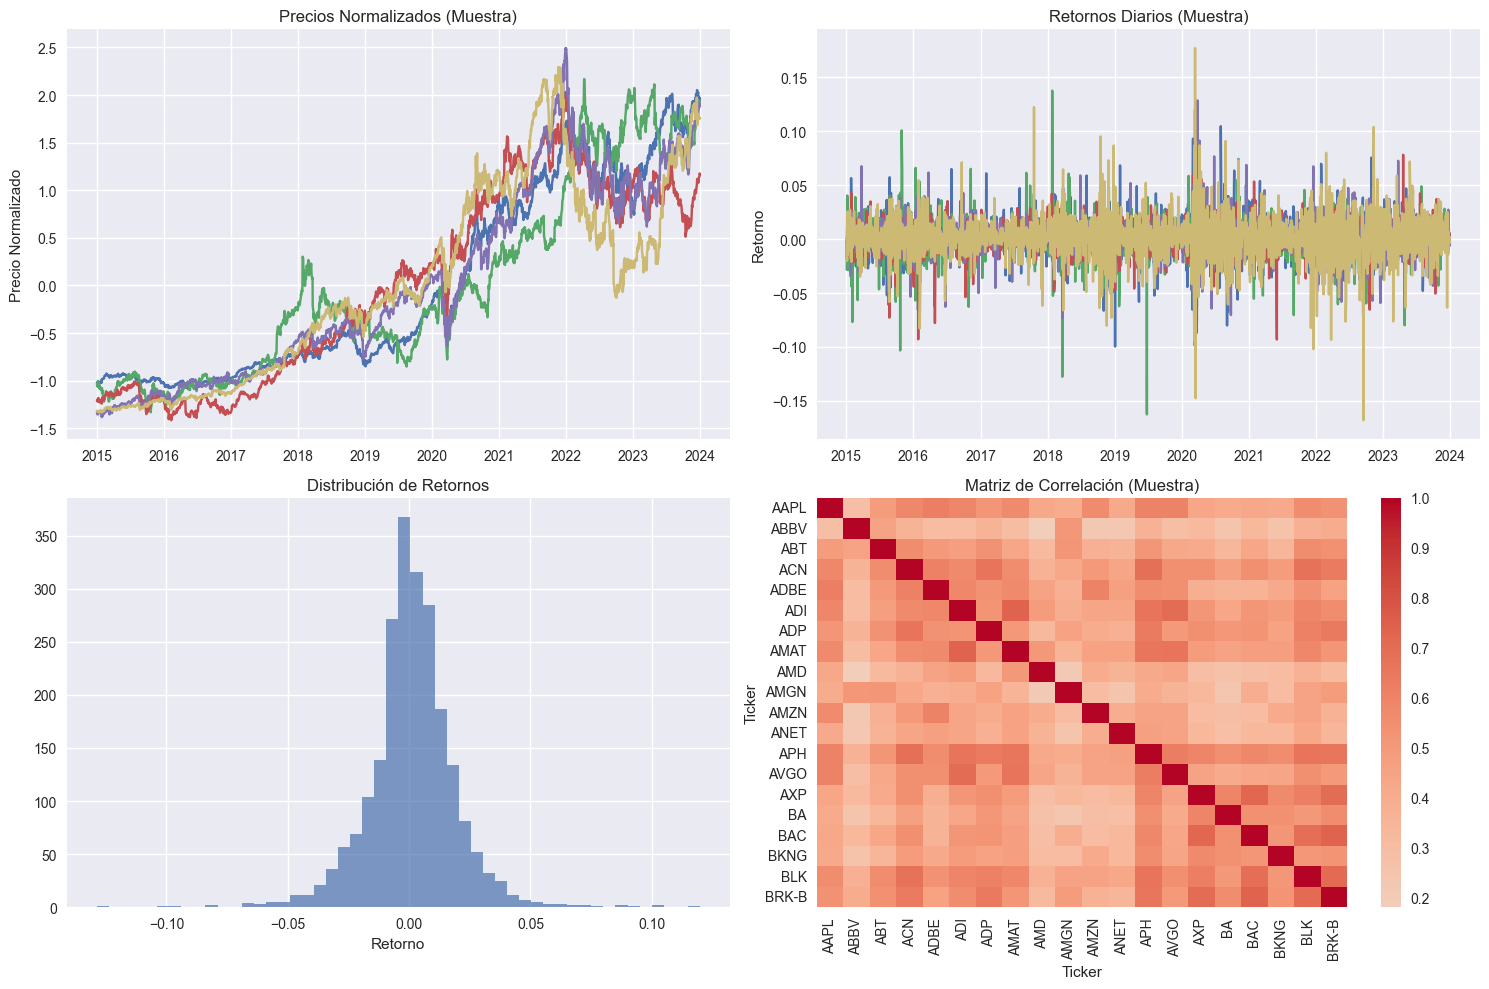

In [15]:
# =======================================================
# üéØ PASO 1: DATASET TEMPORAL FORMALIZADO
# =======================================================

# Configuraci√≥n temporal
START_DATE = '2015-01-01'
END_DATE = '2024-01-01'


print("üèóÔ∏è CONSTRUYENDO DATASET TEMPORAL FORMALIZADO")
print("=" * 50)

# Obtener S&P 500 tickers (usando el enfoque que ya conocemos)
def get_sp500_tickers():
    # URL de la lista del S&P 500
    url = "https://www.slickcharts.com/sp500"


    # Hacer la petici√≥n con headers para evitar bloqueos
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise exception for bad status codes

    # Parsear el HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # Encontrar la tabla
    table = soup.find('table')

    if table:
        # Leer la tabla con pandas
        df = pd.read_html(str(table))[0]
        
        # Extraer los tickers
        if 'Symbol' in df.columns:
            tickers = df['Symbol'].tolist()
            print(f"Found {len(tickers)} tickers")
            
        else:
            print("Available columns:", df.columns.tolist())

        
    else:
        print("No table found on the page")

    # En la lista de ticker, reemplazar los "." por "-"
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    
    return tickers[:120]

# Obtener tickers
tickers = get_sp500_tickers()

# Descargar datos hist√≥ricos
print(f"üì• Descargando datos hist√≥ricos ({START_DATE} a {END_DATE})...")
stock_data = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False)

# Usar solo precios de cierre
if isinstance(stock_data.columns, pd.MultiIndex):
    close_prices = stock_data['Close']
else:
    close_prices = stock_data

# Limpiar datos
close_prices = close_prices.dropna(axis=1, thresh=len(close_prices)*0.8)  # Mantener acciones con >80% datos
close_prices = close_prices.fillna(method='ffill').fillna(method='bfill')

print(f"üìä Dataset final: {close_prices.shape[0]} d√≠as, {close_prices.shape[1]} acciones")
print(f"üìÖ Per√≠odo: {close_prices.index[0].date()} a {close_prices.index[-1].date()}")

# Calcular retornos
returns = close_prices.pct_change().dropna()

# Normalizar precios (para embeddings)
normalized_prices = (close_prices - close_prices.mean()) / close_prices.std()

print("‚úÖ Dataset temporal formalizado completado")

# Visualizaci√≥n r√°pida
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Precios normalizados (muestra)
axes[0,0].plot(normalized_prices.iloc[:, :5])
axes[0,0].set_title('Precios Normalizados (Muestra)')
axes[0,0].set_ylabel('Precio Normalizado')

# Retornos (muestra)
axes[0,1].plot(returns.iloc[:, :5])
axes[0,1].set_title('Retornos Diarios (Muestra)')
axes[0,1].set_ylabel('Retorno')

# Distribuci√≥n de retornos
axes[1,0].hist(returns.iloc[:, 0], bins=50, alpha=0.7)
axes[1,0].set_title('Distribuci√≥n de Retornos')
axes[1,0].set_xlabel('Retorno')

# Correlaci√≥n entre acciones (muestra)
corr_sample = returns.iloc[:, :20].corr()
sns.heatmap(corr_sample, ax=axes[1,1], cmap='coolwarm', center=0)
axes[1,1].set_title('Matriz de Correlaci√≥n (Muestra)')

plt.tight_layout()
plt.show()

ü™ü CREANDO SLIDING WINDOWS
‚úÖ 75 ventanas de retornos creadas
‚úÖ 75 ventanas de precios creadas
üìè Cada ventana: 30 d√≠as √ó 110 acciones
\nüßÆ GENERANDO EMBEDDINGS
üìä Procesando m√©todo: PCA
‚úÖ 75 embeddings generados con pca
üìä Procesando m√©todo: SVD
‚úÖ 75 embeddings generados con svd
\nüìà Embeddings principales: 75 ventanas
üìè Dimensi√≥n por embedding: (110, 10)


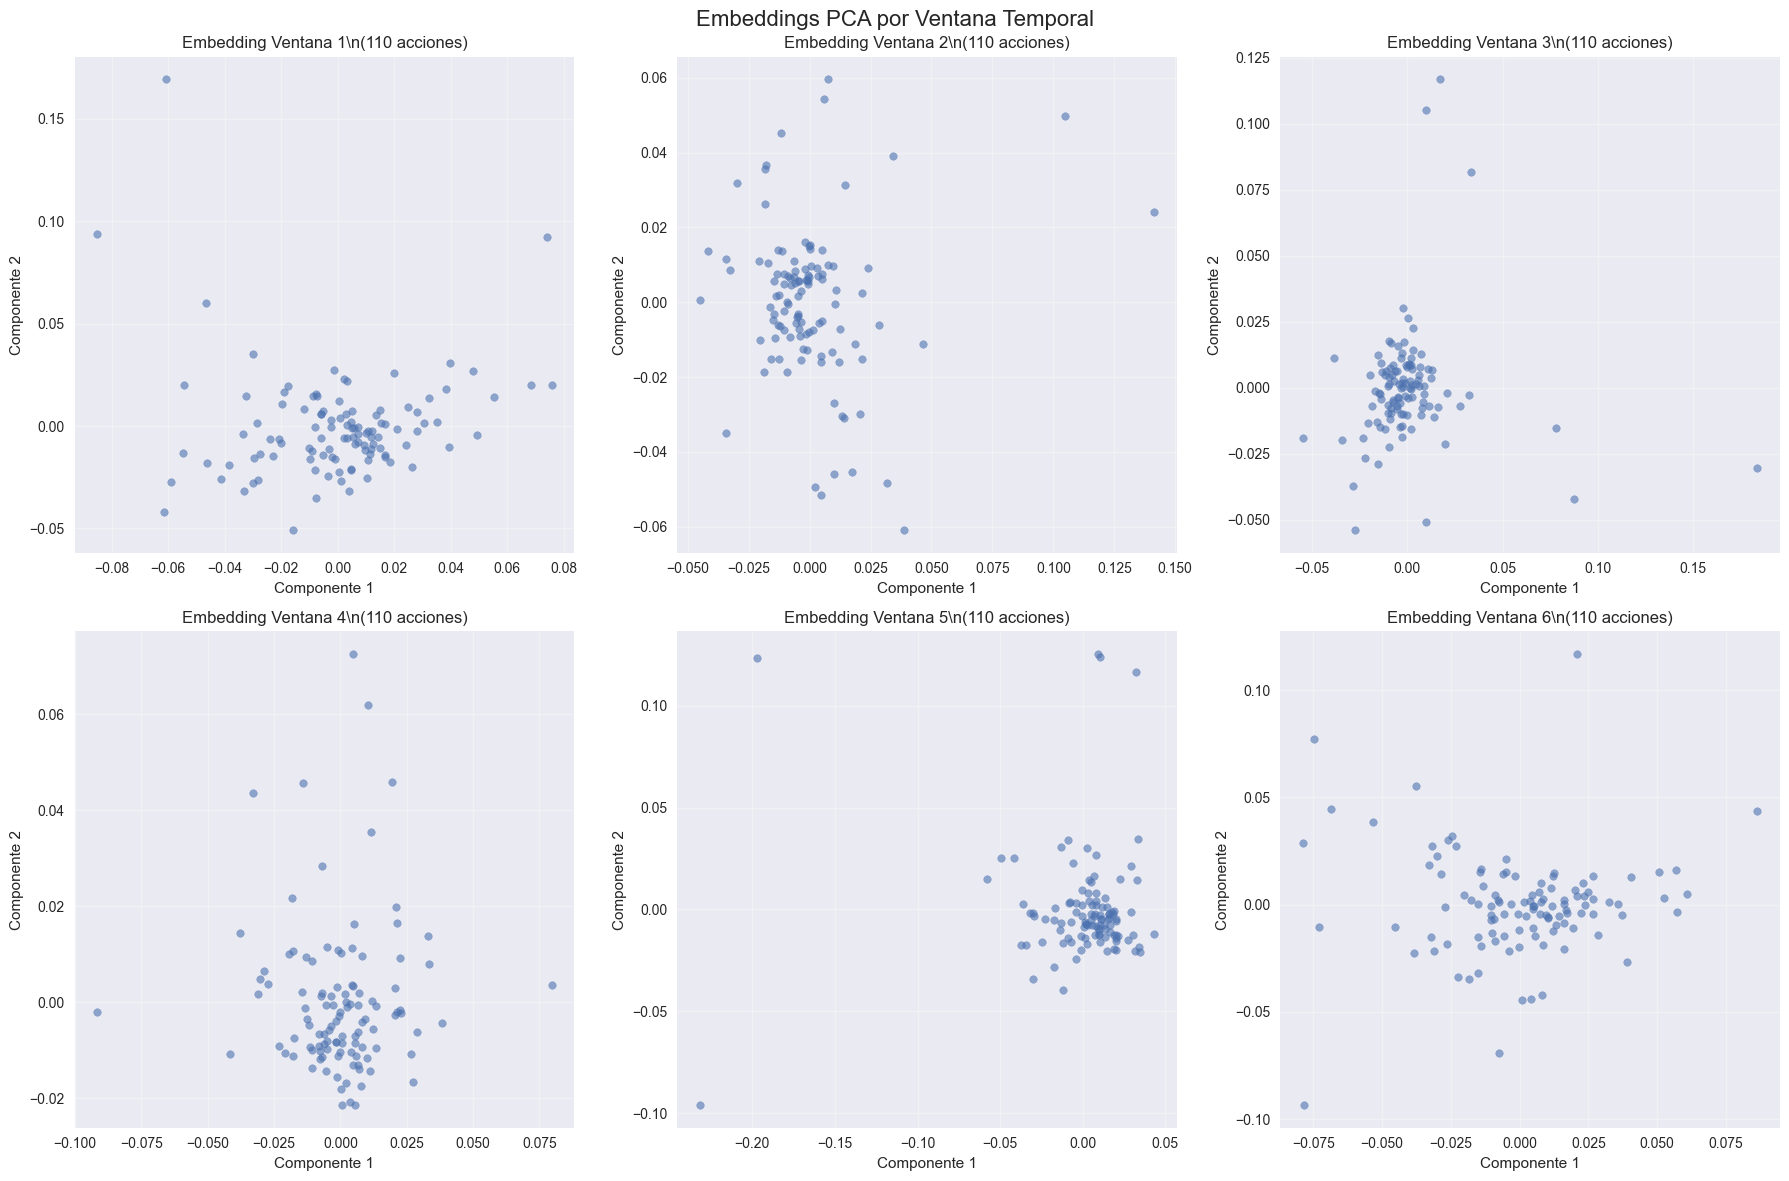

‚úÖ Sliding windows y embeddings completados


In [16]:
# =======================================================
# ü™ü PASO 2: SLIDING WINDOWS Y EMBEDDINGS
# =======================================================

def create_sliding_windows(data, window_size=60, overlap=30):
    """
    Crea sliding windows de los datos temporales
    
    Args:
        data: DataFrame con datos temporales (tiempo √ó acciones)
        window_size: Tama√±o de ventana en d√≠as
        overlap: Solapamiento entre ventanas
    
    Returns:
        list de DataFrames, cada uno una ventana temporal
    """
    windows = []
    step = window_size - overlap
    
    for i in range(0, len(data) - window_size + 1, step):
        window = data.iloc[i:i + window_size]
        if len(window) == window_size:  # Asegurar ventana completa
            windows.append(window)
    
    return windows

print("ü™ü CREANDO SLIDING WINDOWS")
print("=" * 30)

# Crear windows de retornos y precios normalizados
return_windows = create_sliding_windows(returns, WINDOW_SIZE, OVERLAP)
price_windows = create_sliding_windows(normalized_prices, WINDOW_SIZE, OVERLAP)

print(f"‚úÖ {len(return_windows)} ventanas de retornos creadas")
print(f"‚úÖ {len(price_windows)} ventanas de precios creadas")
print(f"üìè Cada ventana: {WINDOW_SIZE} d√≠as √ó {returns.shape[1]} acciones")

# =======================================================
# üßÆ GENERACI√ìN DE EMBEDDINGS POR VENTANA
# =======================================================

def generate_embeddings(windows, method='pca', n_components=10):
    """
    Genera embeddings para cada ventana temporal
    
    Args:
        windows: Lista de DataFrames (ventanas temporales)
        method: 'pca', 'tsne', 'svd'
        n_components: Dimensiones del embedding
    
    Returns:
        embeddings: Lista de arrays numpy con embeddings
        embedders: Lista de objetos entrenados para transformaci√≥n
    """
    embeddings = []
    embedders = []
    
    for i, window in enumerate(windows):
        # Transponer: queremos (acciones √ó tiempo) para embedding
        window_T = window.T.values  # (n_stocks, window_size)
        
        if method == 'pca':
            embedder = PCA(n_components=n_components, random_state=42)
        elif method == 'tsne':
            embedder = TSNE(n_components=min(n_components, 3), random_state=42, perplexity=min(30, len(window_T)-1))
        elif method == 'svd':
            embedder = TruncatedSVD(n_components=n_components, random_state=42)
        else:
            raise ValueError(f"M√©todo {method} no reconocido")
        
        # Fit y transform
        try:
            if method == 'tsne':
                # t-SNE no tiene fit/transform separado
                embedding = embedder.fit_transform(window_T)
            else:
                embedding = embedder.fit_transform(window_T)
            
            embeddings.append(embedding)
            embedders.append(embedder)
            
        except Exception as e:
            print(f"‚ö†Ô∏è Error en ventana {i}: {e}")
            continue
    
    return embeddings, embedders

print("\\nüßÆ GENERANDO EMBEDDINGS")
print("=" * 25)

# Generar embeddings con diferentes m√©todos
embedding_methods = ['pca', 'svd']  # t-SNE muy lento para muchas ventanas
all_embeddings = {}

for method in embedding_methods:
    print(f"üìä Procesando m√©todo: {method.upper()}")
    embeddings, embedders = generate_embeddings(return_windows, method=method, n_components=10)
    all_embeddings[method] = {
        'embeddings': embeddings,
        'embedders': embedders
    }
    print(f"‚úÖ {len(embeddings)} embeddings generados con {method}")

# Usar PCA como m√©todo principal
main_embeddings = all_embeddings['pca']['embeddings']
main_embedders = all_embeddings['pca']['embedders']

print(f"\\nüìà Embeddings principales: {len(main_embeddings)} ventanas")
if main_embeddings:
    print(f"üìè Dimensi√≥n por embedding: {main_embeddings[0].shape}")

# Visualizaci√≥n de embeddings
if len(main_embeddings) > 0:
    # Tomar algunos embeddings para visualizar
    sample_embeddings = main_embeddings[:min(6, len(main_embeddings))]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, embedding in enumerate(sample_embeddings):
        if i < 6:
            # Visualizar en 2D (primeras 2 componentes)
            axes[i].scatter(embedding[:, 0], embedding[:, 1], alpha=0.6, s=30)
            axes[i].set_title(f'Embedding Ventana {i+1}\\n({embedding.shape[0]} acciones)')
            axes[i].set_xlabel('Componente 1')
            axes[i].set_ylabel('Componente 2')
            axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Embeddings PCA por Ventana Temporal', fontsize=16)
    plt.tight_layout()
    plt.show()

print("‚úÖ Sliding windows y embeddings completados")

üï∏Ô∏è APLICANDO TDA A EMBEDDINGS
‚úÖ 75 diagramas de persistencia calculados
üìä Caracter√≠sticas TDA extra√≠das: (75, 11)
üè∑Ô∏è Columnas de caracter√≠sticas: ['window_idx', 'n_components_dim0', 'max_persistence_dim0', 'mean_persistence_dim0', 'std_persistence_dim0', 'persistence_entropy_dim0', 'n_components_dim1', 'max_persistence_dim1', 'mean_persistence_dim1', 'std_persistence_dim1', 'persistence_entropy_dim1']
\nüìà ESTAD√çSTICAS DE CARACTER√çSTICAS TOPOL√ìGICAS:
       window_idx  n_components_dim0  max_persistence_dim0  \
count   75.000000               75.0             75.000000   
mean    37.000000              109.0              7.583578   
std     21.794495                0.0              1.201373   
min      0.000000              109.0              4.319448   
25%     18.500000              109.0              6.856753   
50%     37.000000              109.0              7.480746   
75%     55.500000              109.0              8.535275   
max     74.000000         

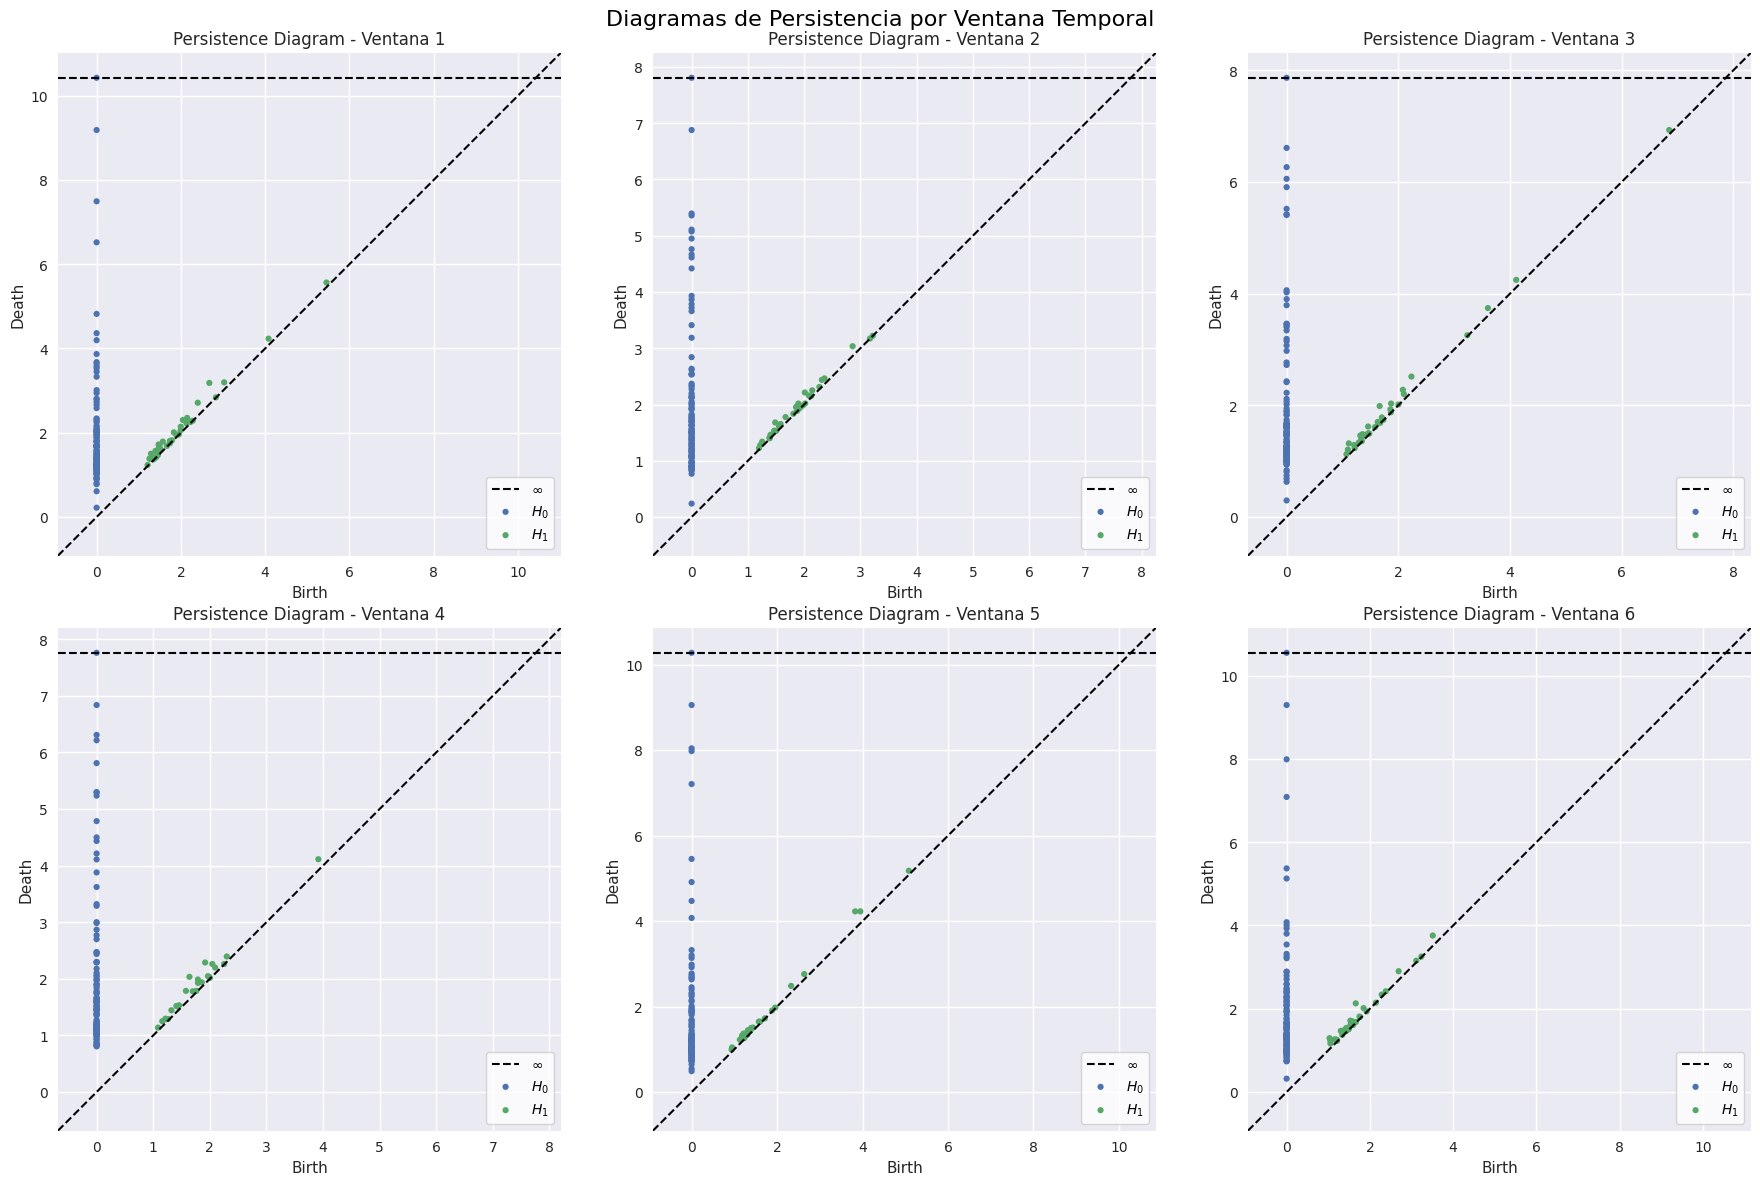

\nüìä CLUSTERING TOPOL√ìGICO DE VENTANAS
‚úÖ 5 clusters identificados
  Cluster 0: 19 ventanas (25.3%)
  Cluster 1: 15 ventanas (20.0%)
  Cluster 2: 23 ventanas (30.7%)
  Cluster 3: 5 ventanas (6.7%)
  Cluster 4: 13 ventanas (17.3%)


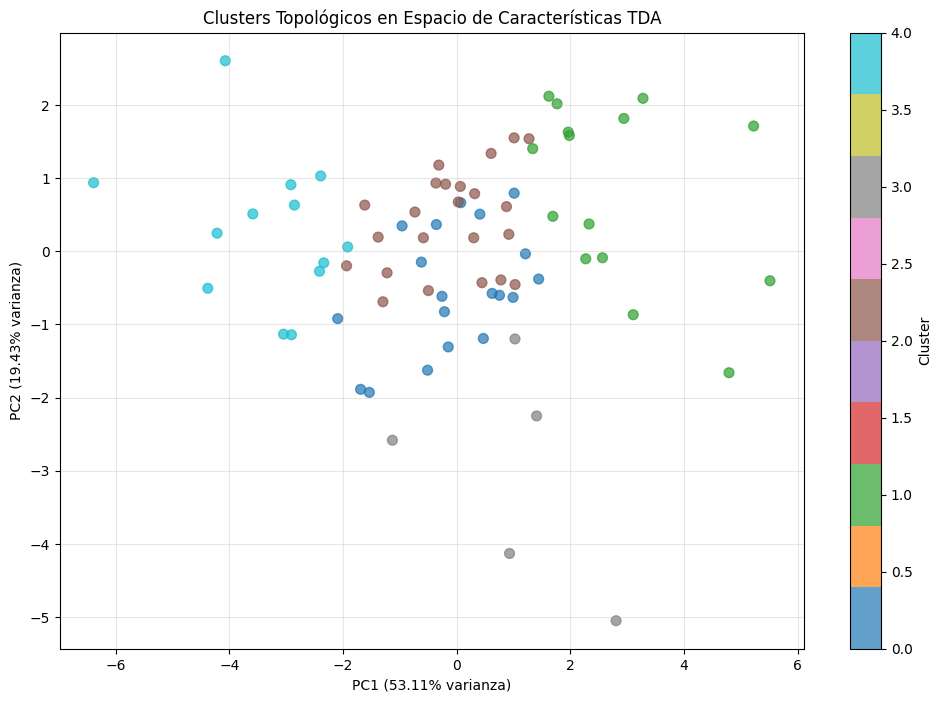

üìä Varianza explicada por PC1+PC2: 72.54%
‚úÖ TDA aplicado exitosamente


In [17]:
# =======================================================
# üï∏Ô∏è PASO 3: TDA - AN√ÅLISIS TOPOL√ìGICO DE EMBEDDINGS
# =======================================================

def compute_persistence_diagrams(embeddings, maxdim=1):
    """
    Calcula diagramas de persistencia para cada embedding
    
    Args:
        embeddings: Lista de arrays numpy con embeddings
        maxdim: Dimensi√≥n m√°xima de homolog√≠a
    
    Returns:
        persistence_diagrams: Lista de diagramas de persistencia
        tda_features: DataFrame con caracter√≠sticas topol√≥gicas extra√≠das
    """
    persistence_diagrams = []
    tda_features_list = []
    
    for i, embedding in enumerate(embeddings):
        try:
            # Normalizar embedding
            scaler = StandardScaler()
            embedding_scaled = scaler.fit_transform(embedding)
            
            # Calcular diagrama de persistencia
            dgms = ripser(embedding_scaled, maxdim=maxdim)['dgms']
            persistence_diagrams.append(dgms)
            
            # Extraer caracter√≠sticas topol√≥gicas
            features = extract_topological_features(dgms, window_idx=i)
            tda_features_list.append(features)
            
        except Exception as e:
            print(f"‚ö†Ô∏è Error en embedding {i}: {e}")
            continue
    
    tda_features_df = pd.DataFrame(tda_features_list)
    return persistence_diagrams, tda_features_df

def extract_topological_features(dgms, window_idx):
    """Extrae caracter√≠sticas num√©ricas de diagramas de persistencia"""
    features = {'window_idx': window_idx}
    
    for dim, dgm in enumerate(dgms):
        # Filtrar puntos infinitos
        finite_dgm = dgm[np.isfinite(dgm).all(axis=1)]
        
        if len(finite_dgm) > 0:
            # Caracter√≠sticas b√°sicas
            features[f'n_components_dim{dim}'] = len(finite_dgm)
            features[f'max_persistence_dim{dim}'] = np.max(finite_dgm[:, 1] - finite_dgm[:, 0])
            features[f'mean_persistence_dim{dim}'] = np.mean(finite_dgm[:, 1] - finite_dgm[:, 0])
            features[f'std_persistence_dim{dim}'] = np.std(finite_dgm[:, 1] - finite_dgm[:, 0])
            
            # Persistence entropy (medida de complejidad topol√≥gica)
            persistences = finite_dgm[:, 1] - finite_dgm[:, 0]
            if persistences.sum() > 0:
                normalized_pers = persistences / persistences.sum()
                entropy = -np.sum(normalized_pers * np.log(normalized_pers + 1e-10))
                features[f'persistence_entropy_dim{dim}'] = entropy
            else:
                features[f'persistence_entropy_dim{dim}'] = 0
        else:
            # Sin componentes
            features[f'n_components_dim{dim}'] = 0
            features[f'max_persistence_dim{dim}'] = 0
            features[f'mean_persistence_dim{dim}'] = 0
            features[f'std_persistence_dim{dim}'] = 0
            features[f'persistence_entropy_dim{dim}'] = 0
    
    return features

print("üï∏Ô∏è APLICANDO TDA A EMBEDDINGS")
print("=" * 35)

# Calcular diagramas de persistencia
persistence_diagrams, tda_features = compute_persistence_diagrams(main_embeddings, maxdim=1)

print(f"‚úÖ {len(persistence_diagrams)} diagramas de persistencia calculados")
print(f"üìä Caracter√≠sticas TDA extra√≠das: {tda_features.shape}")
print(f"üè∑Ô∏è Columnas de caracter√≠sticas: {list(tda_features.columns)}")

# Mostrar estad√≠sticas de caracter√≠sticas TDA
print("\\nüìà ESTAD√çSTICAS DE CARACTER√çSTICAS TOPOL√ìGICAS:")
print(tda_features.describe())

# Visualizar algunos diagramas de persistencia
if len(persistence_diagrams) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i in range(min(6, len(persistence_diagrams))):
        try:
            # Visualizar diagrama de persistencia
            plot_diagrams(persistence_diagrams[i], ax=axes[i], show=False)
            axes[i].set_title(f'Persistence Diagram - Ventana {i+1}')
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error: {str(e)[:30]}...', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Ventana {i+1} (Error)')
    
    plt.suptitle('Diagramas de Persistencia por Ventana Temporal', fontsize=16)
    plt.tight_layout()
    plt.show()

# =======================================================
# üìä CLUSTERING TOPOL√ìGICO DE ACCIONES
# =======================================================

def cluster_stocks_by_topology(embeddings, tda_features, n_clusters=5, method='kmeans'):
    """
    Agrupa acciones bas√°ndose en caracter√≠sticas topol√≥gicas
    
    Args:
        embeddings: Lista de embeddings
        tda_features: DataFrame con caracter√≠sticas TDA
        n_clusters: N√∫mero de clusters
        method: 'kmeans' o 'dbscan'
    
    Returns:
        cluster_labels: Etiquetas de cluster por ventana
        clusterer: Objeto clustering entrenado
    """
    # Usar caracter√≠sticas TDA para clustering
    feature_cols = [col for col in tda_features.columns if col != 'window_idx']
    X_tda = tda_features[feature_cols].fillna(0)
    
    # Normalizar caracter√≠sticas
    scaler = StandardScaler()
    X_tda_scaled = scaler.fit_transform(X_tda)
    
    if method == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == 'dbscan':
        clusterer = DBSCAN(eps=0.5, min_samples=3)
    
    cluster_labels = clusterer.fit_predict(X_tda_scaled)
    
    return cluster_labels, clusterer, X_tda_scaled

print("\\nüìä CLUSTERING TOPOL√ìGICO DE VENTANAS")
print("=" * 40)

# Realizar clustering
cluster_labels, clusterer, X_tda_scaled = cluster_stocks_by_topology(
    main_embeddings, tda_features, n_clusters=5
)

# An√°lisis de clusters
unique_labels = np.unique(cluster_labels)
print(f"‚úÖ {len(unique_labels)} clusters identificados")

for label in unique_labels:
    count = np.sum(cluster_labels == label)
    percentage = count / len(cluster_labels) * 100
    print(f"  Cluster {label}: {count} ventanas ({percentage:.1f}%)")

# Visualizar clusters en espacio TDA
if X_tda_scaled.shape[1] >= 2:
    # PCA para visualizaci√≥n
    pca_vis = PCA(n_components=2, random_state=42)
    X_vis = pca_vis.fit_transform(X_tda_scaled)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=cluster_labels, 
                         cmap='tab10', alpha=0.7, s=50)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(f'PC1 ({pca_vis.explained_variance_ratio_[0]:.2%} varianza)')
    plt.ylabel(f'PC2 ({pca_vis.explained_variance_ratio_[1]:.2%} varianza)')
    plt.title('Clusters Topol√≥gicos en Espacio de Caracter√≠sticas TDA')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"üìä Varianza explicada por PC1+PC2: {pca_vis.explained_variance_ratio_.sum():.2%}")

print("‚úÖ TDA aplicado exitosamente")

üí• DETECCI√ìN DE RUPTURES EN SERIES TEMPORALES
üìà √çndice de mercado analizado: 2264 d√≠as
üí• Puntos de cambio detectados: 67
üìÖ Fechas de cambios principales:
  1. 2015-02-09
  2. 2015-02-24
  3. 2015-08-14
  4. 2015-09-28
  5. 2015-11-02
  6. 2015-12-08
  7. 2016-02-22
  8. 2016-06-22
  9. 2016-07-14
  10. 2016-09-09
  11. 2016-09-30
  12. 2016-11-04
  13. 2018-01-02
  14. 2018-01-24
  15. 2018-03-22
  16. 2018-04-06
  17. 2018-10-03
  18. 2018-11-14
  19. 2019-01-08
  20. 2019-02-06
  21. 2019-05-03
  22. 2019-06-03
  23. 2019-07-30
  24. 2019-08-13
  25. 2019-09-04
  26. 2019-10-02
  27. 2019-10-16
  28. 2020-01-21
  29. 2020-02-19
  30. 2020-03-04
  31. 2020-04-01
  32. 2020-04-30
  33. 2020-06-19
  34. 2020-07-06
  35. 2020-08-03
  36. 2020-08-31
  37. 2020-11-24
  38. 2020-12-23
  39. 2021-01-08
  40. 2021-01-25
  41. 2021-02-08
  42. 2021-02-23
  43. 2021-03-09
  44. 2021-05-26
  45. 2021-09-13
  46. 2021-10-04
  47. 2021-11-08
  48. 2021-11-22
  49. 2021-12-07
  50. 20

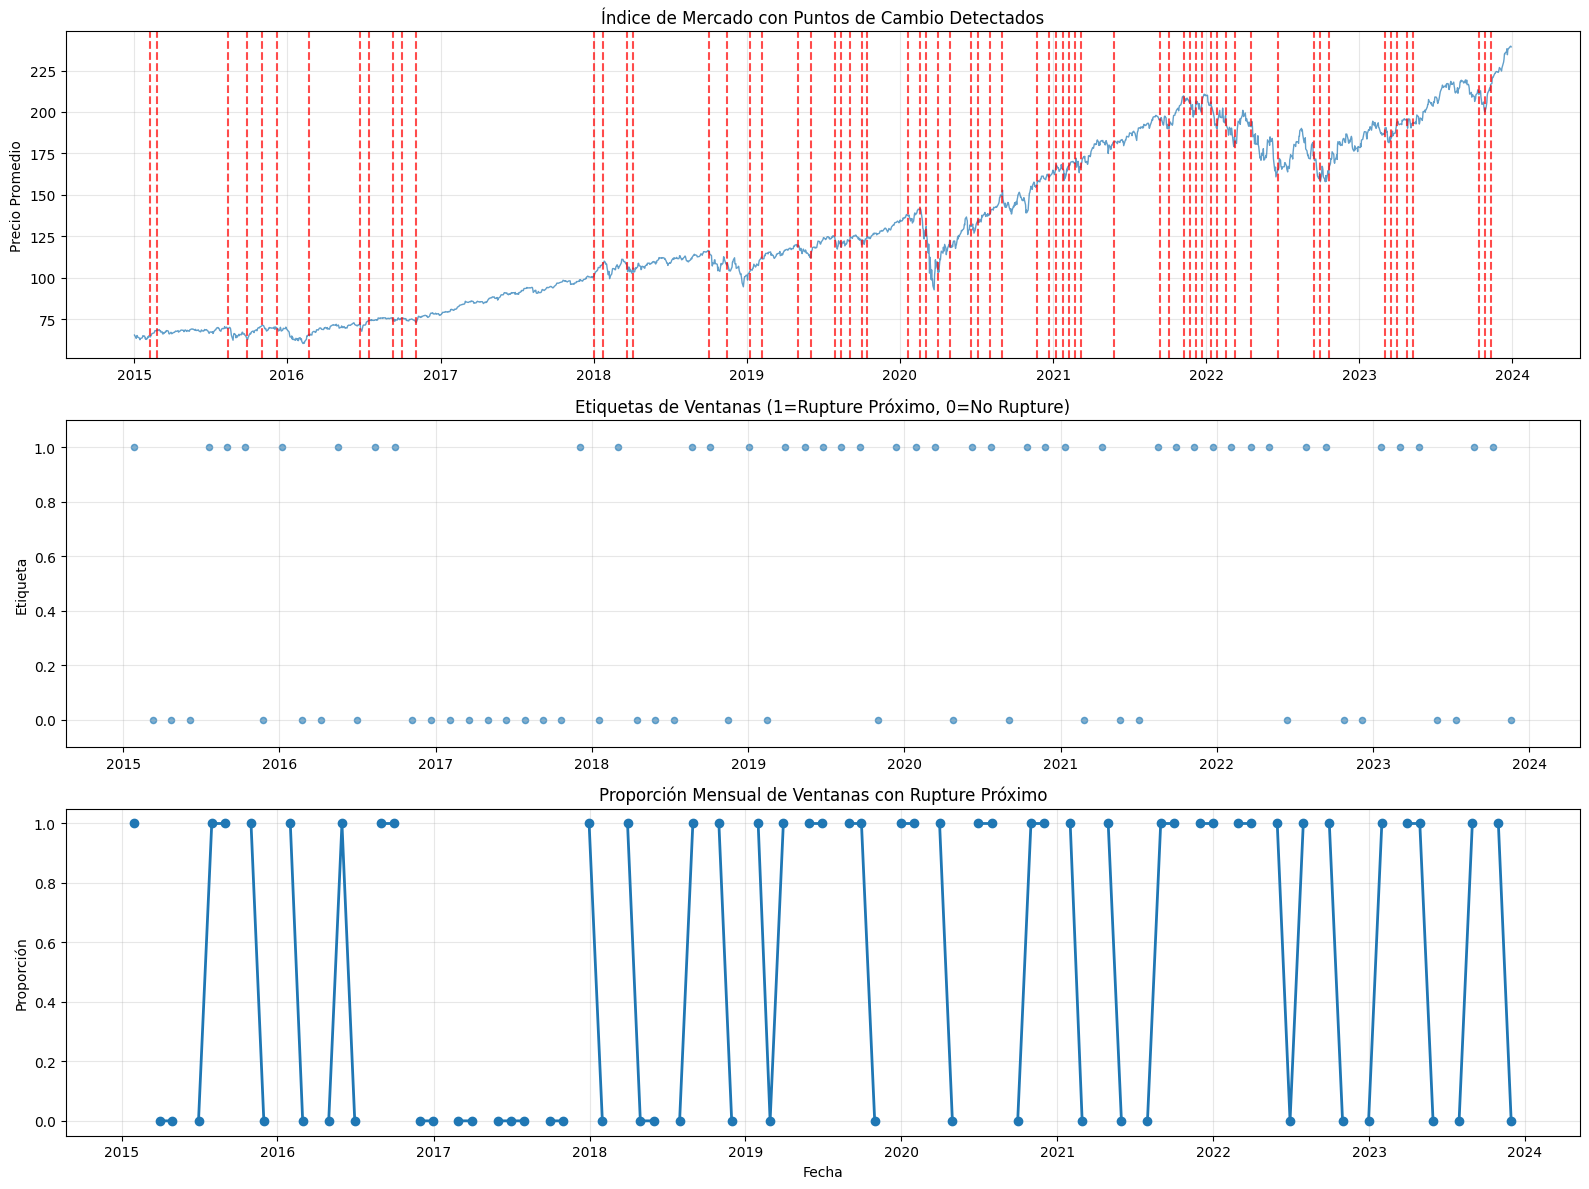

\nüìä AN√ÅLISIS POR PER√çODOS CR√çTICOS:
  COVID-19 2020: 50.0% ventanas con rupture pr√≥ximo
  Inflaci√≥n/Fed 2022: 62.5% ventanas con rupture pr√≥ximo
‚úÖ Detecci√≥n de ruptures y etiquetado completado


In [18]:
# =======================================================
# üí• PASO 4: DETECCI√ìN DE RUPTURES Y ETIQUETADO
# =======================================================

def detect_changepoints(price_series, method='pelt', model='rbf', min_size=10):
    """
    Detecta puntos de cambio en series temporales usando ruptures
    
    Args:
        price_series: Serie temporal de precios
        method: 'pelt', 'binseg', 'window'
        model: 'l1', 'l2', 'rbf', 'normal'
        min_size: Tama√±o m√≠nimo de segmento
    
    Returns:
        changepoints: Lista de √≠ndices de cambio
        n_changes: N√∫mero de cambios detectados
    """
    # Usar retornos en lugar de precios para mejor detecci√≥n
    returns_series = price_series.pct_change().dropna()
    
    # Configurar algoritmo
    if method == 'pelt':
        algo = rpt.Pelt(model=model, min_size=min_size)
    elif method == 'binseg':
        algo = rpt.Binseg(model=model, min_size=min_size)
    elif method == 'window':
        algo = rpt.Window(width=50, model=model, min_size=min_size)
    
    # Detectar cambios
    algo.fit(returns_series.values.reshape(-1, 1))
    changepoints = algo.predict(pen=1.0)  # penalty parameter
    
    # Remover el √∫ltimo punto (siempre es len(data))
    if changepoints[-1] == len(returns_series):
        changepoints = changepoints[:-1]
    
    return changepoints, len(changepoints)

print("üí• DETECCI√ìN DE RUPTURES EN SERIES TEMPORALES")
print("=" * 50)

# Detectar cambios en el √≠ndice general (promedio del mercado)
market_index = close_prices.mean(axis=1)
market_changepoints, n_market_changes = detect_changepoints(market_index)

print(f"üìà √çndice de mercado analizado: {len(market_index)} d√≠as")
print(f"üí• Puntos de cambio detectados: {n_market_changes}")

# Convertir √≠ndices a fechas
market_change_dates = [market_index.index[cp] for cp in market_changepoints]
print(f"üìÖ Fechas de cambios principales:")
for i, date in enumerate(market_change_dates):
    print(f"  {i+1}. {date.date()}")

# Detectar cambios en acciones individuales (muestra)
sample_stocks = list(close_prices.columns[:10])
stock_changepoints = {}

print(f"\\nüîç Analizando cambios en acciones individuales (muestra)...")
for stock in sample_stocks:
    changepoints, n_changes = detect_changepoints(close_prices[stock])
    stock_changepoints[stock] = changepoints
    print(f"  {stock}: {n_changes} cambios detectados")

# =======================================================
# üè∑Ô∏è ETIQUETADO DE VENTANAS SEG√öN PROXIMIDAD A RUPTURES
# =======================================================

def label_windows_by_ruptures(return_windows, changepoints, prediction_horizon=30):
    """
    Etiqueta ventanas seg√∫n si preceden a un rupture
    
    Args:
        return_windows: Lista de ventanas temporales
        changepoints: Lista de puntos de cambio
        prediction_horizon: D√≠as hacia adelante para considerar 'pr√≥ximo'
    
    Returns:
        labels: Lista de etiquetas binarias (1=rupture pr√≥ximo, 0=no)
        window_dates: Lista de fechas centrales de cada ventana
    """
    labels = []
    window_dates = []
    
    for window in return_windows:
        # Fecha central de la ventana
        center_date = window.index[len(window)//2]
        window_dates.append(center_date)
        
        # Fecha final de la ventana
        end_date = window.index[-1]
        
        # Buscar si hay alg√∫n changepoint en el horizonte de predicci√≥n
        rupture_near = False
        for cp_idx in changepoints:
            cp_date = market_index.index[cp_idx]
            days_to_rupture = (cp_date - end_date).days
            
            if 0 <= days_to_rupture <= prediction_horizon:
                rupture_near = True
                break
        
        labels.append(1 if rupture_near else 0)
    
    return labels, window_dates

# Etiquetar ventanas
rupture_labels, window_dates = label_windows_by_ruptures(
    return_windows, market_changepoints, prediction_horizon=30
)

print(f"\\nüè∑Ô∏è ETIQUETADO DE VENTANAS COMPLETADO")
print("=" * 40)
print(f"üìä Total de ventanas etiquetadas: {len(rupture_labels)}")
print(f"üí• Ventanas con rupture pr√≥ximo: {sum(rupture_labels)} ({sum(rupture_labels)/len(rupture_labels)*100:.1f}%)")
print(f"‚úÖ Ventanas sin rupture pr√≥ximo: {len(rupture_labels)-sum(rupture_labels)} ({(len(rupture_labels)-sum(rupture_labels))/len(rupture_labels)*100:.1f}%)")

# Visualizaci√≥n de ruptures y etiquetado
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Serie temporal con puntos de cambio
axes[0].plot(market_index.index, market_index.values, linewidth=1, alpha=0.7)
for cp_date in market_change_dates:
    axes[0].axvline(x=cp_date, color='red', linestyle='--', alpha=0.7)
axes[0].set_title('√çndice de Mercado con Puntos de Cambio Detectados')
axes[0].set_ylabel('Precio Promedio')
axes[0].grid(True, alpha=0.3)

# 2. Distribuci√≥n temporal de etiquetas
window_dates_series = pd.Series(rupture_labels, index=window_dates)
axes[1].scatter(window_dates, rupture_labels, alpha=0.6, s=20)
axes[1].set_title('Etiquetas de Ventanas (1=Rupture Pr√≥ximo, 0=No Rupture)')
axes[1].set_ylabel('Etiqueta')
axes[1].set_ylim(-0.1, 1.1)
axes[1].grid(True, alpha=0.3)

# 3. An√°lisis temporal de ruptures
monthly_ruptures = pd.Series(rupture_labels, index=window_dates).resample('M').mean()
axes[2].plot(monthly_ruptures.index, monthly_ruptures.values, marker='o', linewidth=2)
axes[2].set_title('Proporci√≥n Mensual de Ventanas con Rupture Pr√≥ximo')
axes[2].set_ylabel('Proporci√≥n')
axes[2].set_xlabel('Fecha')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# An√°lisis por per√≠odos cr√≠ticos
print(f"\\nüìä AN√ÅLISIS POR PER√çODOS CR√çTICOS:")
critical_periods = [
    ('2008-09-01', '2009-03-01', 'Crisis Financiera 2008'),
    ('2020-02-01', '2020-05-01', 'COVID-19 2020'),
    ('2022-01-01', '2022-12-31', 'Inflaci√≥n/Fed 2022')
]

for start, end, name in critical_periods:
    period_mask = (pd.Series(window_dates) >= start) & (pd.Series(window_dates) <= end)
    if period_mask.any():
        period_labels = np.array(rupture_labels)[period_mask]
        rupture_rate = period_labels.mean()
        print(f"  {name}: {rupture_rate:.1%} ventanas con rupture pr√≥ximo")

print("‚úÖ Detecci√≥n de ruptures y etiquetado completado")

ü§ñ ENTRENAMIENTO DE MODELOS PREDICTIVOS
üìä Dataset predictivo creado:
   Features: 14 caracter√≠sticas
   Muestras: 75 ventanas
   Distribuci√≥n target: [34 41] (No-Rupture: 34, Rupture: 41)
\nüìÖ Divisi√≥n temporal:
   Entrenamiento: 52 muestras
   Test: 23 muestras
\nüå≤ Entrenando Random Forest para predicci√≥n de ruptures...
\nüìä RESULTADOS RANDOM FOREST:
   Accuracy: 0.609
   AUC: 0.525
\nüìã Classification Report:
              precision    recall  f1-score   support

  No-Rupture       0.44      0.50      0.47         8
     Rupture       0.71      0.67      0.69        15

    accuracy                           0.61        23
   macro avg       0.58      0.58      0.58        23
weighted avg       0.62      0.61      0.61        23

\nüéØ TOP 10 CARACTER√çSTICAS M√ÅS IMPORTANTES:
    1. max_persistence_dim1     : 0.1334
    2. persistence_entropy_dim1 : 0.1271
    3. mean_persistence_dim0    : 0.1111
    4. persistence_entropy_dim0 : 0.0918
    5. std_persistence_dim0

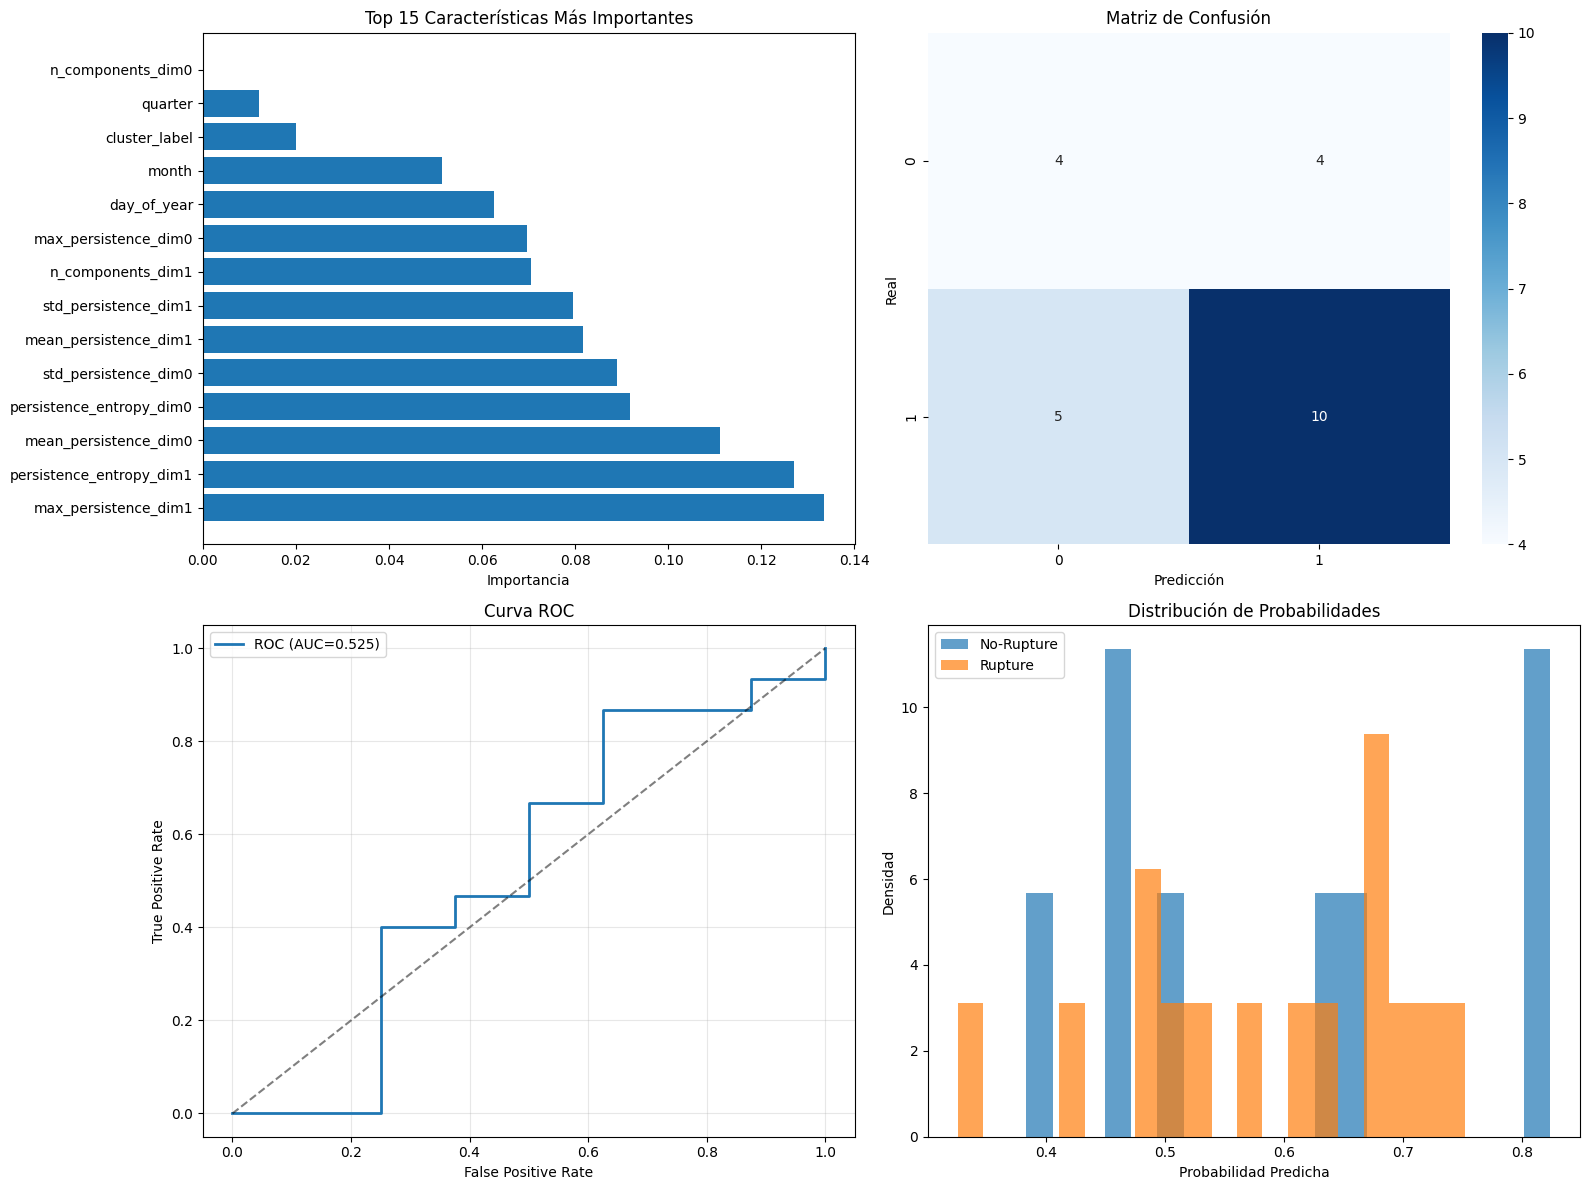

\nüîÆ AN√ÅLISIS TEMPORAL DE PREDICCIONES:
üìÖ Performance anual:
      total_windows  true_ruptures  pred_ruptures  avg_proba  precision
date                                                                   
2021              7              5              3      0.529      0.714
2022              8              5              8      0.671      0.625
2023              8              5              3      0.552      0.500


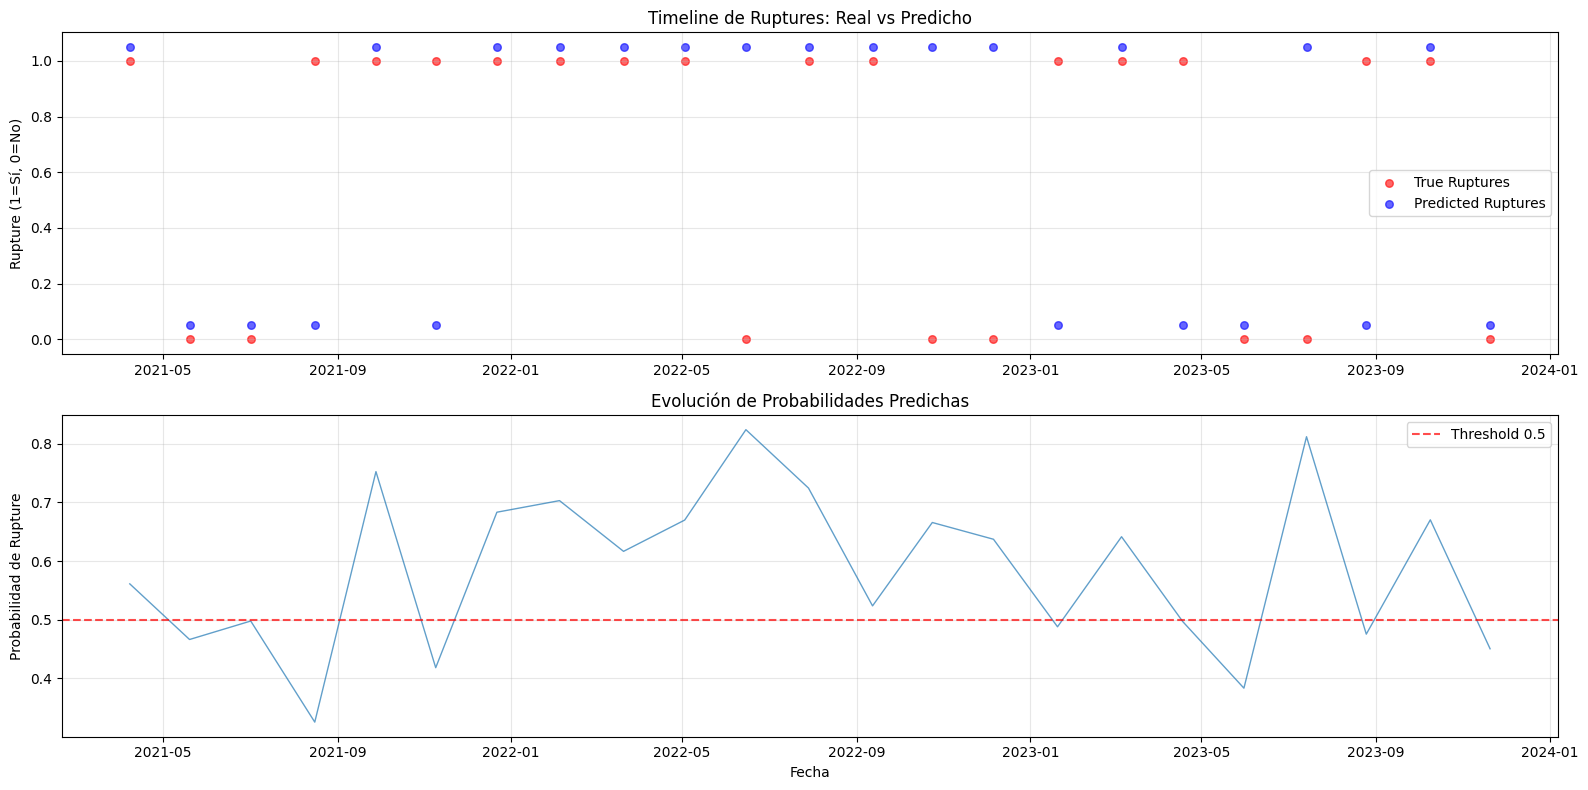

‚úÖ Modelos predictivos entrenados y evaluados


In [19]:
# =======================================================
# ü§ñ PASO 5: MODELOS PREDICTIVOS TOPOL√ìGICOS
# =======================================================

def create_predictive_dataset(tda_features, cluster_labels, rupture_labels, window_dates):
    """
    Crea dataset para modelos predictivos combinando caracter√≠sticas TDA y clusters
    """
    # Combinar todas las caracter√≠sticas
    feature_cols = [col for col in tda_features.columns if col != 'window_idx']
    X_features = tda_features[feature_cols].fillna(0)
    
    # A√±adir cluster como caracter√≠stica
    X_features['cluster_label'] = cluster_labels
    
    # A√±adir caracter√≠sticas temporales
    dates_df = pd.DataFrame({'date': window_dates})
    dates_df['month'] = dates_df['date'].dt.month
    dates_df['quarter'] = dates_df['date'].dt.quarter
    dates_df['year'] = dates_df['date'].dt.year
    dates_df['day_of_year'] = dates_df['date'].dt.dayofyear
    
    # Combinar caracter√≠sticas
    X_combined = pd.concat([X_features.reset_index(drop=True), 
                           dates_df[['month', 'quarter', 'day_of_year']].reset_index(drop=True)], 
                          axis=1)
    
    return X_combined, np.array(rupture_labels)

print("ü§ñ ENTRENAMIENTO DE MODELOS PREDICTIVOS")
print("=" * 45)

# Crear dataset para predicci√≥n
X_pred, y_pred = create_predictive_dataset(tda_features, cluster_labels, rupture_labels, window_dates)

print(f"üìä Dataset predictivo creado:")
print(f"   Features: {X_pred.shape[1]} caracter√≠sticas")
print(f"   Muestras: {X_pred.shape[0]} ventanas")
print(f"   Distribuci√≥n target: {np.bincount(y_pred)} (No-Rupture: {np.bincount(y_pred)[0]}, Rupture: {np.bincount(y_pred)[1]})")

# Divisi√≥n temporal para validaci√≥n (importante en series temporales)
split_idx = int(len(X_pred) * 0.7)  # 70% entrenamiento, 30% test

X_train = X_pred.iloc[:split_idx]
X_test = X_pred.iloc[split_idx:]
y_train = y_pred[:split_idx]
y_test = y_pred[split_idx:]

print(f"\\nüìÖ Divisi√≥n temporal:")
print(f"   Entrenamiento: {len(X_train)} muestras")
print(f"   Test: {len(X_test)} muestras")

# =======================================================
# üå≤ RANDOM FOREST PARA PREDICCI√ìN DE RUPTURES
# =======================================================

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Entrenar Random Forest
rf_rupture = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    class_weight='balanced',  # Importante para clases desbalanceadas
    random_state=42,
    n_jobs=-1
)

print("\\nüå≤ Entrenando Random Forest para predicci√≥n de ruptures...")
rf_rupture.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_rupture.predict(X_test)
y_proba_rf = rf_rupture.predict_proba(X_test)[:, 1]

# M√©tricas
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"\\nüìä RESULTADOS RANDOM FOREST:")
print(f"   Accuracy: {accuracy_rf:.3f}")
print(f"   AUC: {auc_rf:.3f}")
print("\\nüìã Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No-Rupture', 'Rupture']))

# Importancia de caracter√≠sticas
feature_importance = pd.DataFrame({
    'feature': X_pred.columns,
    'importance': rf_rupture.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\\nüéØ TOP 10 CARACTER√çSTICAS M√ÅS IMPORTANTES:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"   {i+1:2d}. {row['feature']:25s}: {row['importance']:.4f}")

# =======================================================
# üìà VISUALIZACIONES DE RESULTADOS
# =======================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Importancia de caracter√≠sticas
top_features = feature_importance.head(15)
axes[0,0].barh(range(len(top_features)), top_features['importance'])
axes[0,0].set_yticks(range(len(top_features)))
axes[0,0].set_yticklabels(top_features['feature'])
axes[0,0].set_title('Top 15 Caracter√≠sticas M√°s Importantes')
axes[0,0].set_xlabel('Importancia')

# 2. Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Matriz de Confusi√≥n')
axes[0,1].set_xlabel('Predicci√≥n')
axes[0,1].set_ylabel('Real')

# 3. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
axes[1,0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={auc_rf:.3f})')
axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('Curva ROC')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Distribuci√≥n de probabilidades
axes[1,1].hist(y_proba_rf[y_test==0], bins=20, alpha=0.7, label='No-Rupture', density=True)
axes[1,1].hist(y_proba_rf[y_test==1], bins=20, alpha=0.7, label='Rupture', density=True)
axes[1,1].set_xlabel('Probabilidad Predicha')
axes[1,1].set_ylabel('Densidad')
axes[1,1].set_title('Distribuci√≥n de Probabilidades')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# =======================================================
# üîÆ AN√ÅLISIS TEMPORAL DE PREDICCIONES
# =======================================================

# Crear serie temporal de predicciones
test_dates = window_dates[split_idx:]
predictions_ts = pd.DataFrame({
    'date': test_dates,
    'true_label': y_test,
    'pred_label': y_pred_rf,
    'pred_proba': y_proba_rf
})

print(f"\\nüîÆ AN√ÅLISIS TEMPORAL DE PREDICCIONES:")
print("=" * 40)

# An√°lisis por a√±o
yearly_performance = predictions_ts.groupby(predictions_ts['date'].dt.year).agg({
    'true_label': ['count', 'sum'],
    'pred_label': 'sum',
    'pred_proba': 'mean'
}).round(3)

yearly_performance.columns = ['total_windows', 'true_ruptures', 'pred_ruptures', 'avg_proba']
yearly_performance['precision'] = yearly_performance.apply(
    lambda row: accuracy_score(
        predictions_ts[predictions_ts['date'].dt.year == row.name]['true_label'],
        predictions_ts[predictions_ts['date'].dt.year == row.name]['pred_label']
    ), axis=1
).round(3)

print("üìÖ Performance anual:")
print(yearly_performance)

# Visualizaci√≥n temporal
plt.figure(figsize=(16, 8))

# Timeline de predicciones
plt.subplot(2, 1, 1)
plt.scatter(predictions_ts['date'], predictions_ts['true_label'], 
           alpha=0.6, s=30, label='True Ruptures', color='red')
plt.scatter(predictions_ts['date'], predictions_ts['pred_label'] + 0.05, 
           alpha=0.6, s=30, label='Predicted Ruptures', color='blue')
plt.ylabel('Rupture (1=S√≠, 0=No)')
plt.title('Timeline de Ruptures: Real vs Predicho')
plt.legend()
plt.grid(True, alpha=0.3)

# Probabilidades a lo largo del tiempo
plt.subplot(2, 1, 2)
plt.plot(predictions_ts['date'], predictions_ts['pred_proba'], alpha=0.7, linewidth=1)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Threshold 0.5')
plt.ylabel('Probabilidad de Rupture')
plt.xlabel('Fecha')
plt.title('Evoluci√≥n de Probabilidades Predichas')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("‚úÖ Modelos predictivos entrenados y evaluados")

In [20]:
# =======================================================
# üíé PASO 6: CREACI√ìN DE √çNDICES TOPOL√ìGICOS
# =======================================================

class TopologicalIndexBuilder:
    """
    Construye √≠ndices basados en similaridad topol√≥gica
    """
    
    def __init__(self, embeddings, tda_features, stock_names, cluster_labels):
        self.embeddings = embeddings
        self.tda_features = tda_features
        self.stock_names = stock_names
        self.cluster_labels = cluster_labels
        
    def compute_topological_similarity(self, window_idx):
        """Calcula matriz de similaridad topol√≥gica para una ventana"""
        if window_idx >= len(self.embeddings):
            return None
            
        embedding = self.embeddings[window_idx]
        n_stocks = len(embedding)
        
        # Matriz de similaridad basada en distancia en embedding
        similarity_matrix = np.zeros((n_stocks, n_stocks))
        
        for i in range(n_stocks):
            for j in range(n_stocks):
                # Distancia euclidiana en espacio de embedding
                dist = np.linalg.norm(embedding[i] - embedding[j])
                # Convertir a similaridad (m√°s cercano = m√°s similar)
                similarity_matrix[i, j] = 1 / (1 + dist)
        
        return similarity_matrix
    
    def create_topological_index(self, window_idx, selection_method='top_similar', n_stocks=20):
        """
        Crea un √≠ndice topol√≥gico para una ventana espec√≠fica
        
        Args:
            window_idx: √çndice de ventana temporal
            selection_method: 'top_similar', 'cluster_based', 'persistence_weighted'
            n_stocks: N√∫mero de acciones a incluir
        
        Returns:
            selected_stocks: Lista de acciones seleccionadas
            weights: Pesos de cada acci√≥n
        """
        similarity_matrix = self.compute_topological_similarity(window_idx)
        if similarity_matrix is None:
            return [], []
        
        if selection_method == 'top_similar':
            # Seleccionar acciones m√°s similares al centroide topol√≥gico
            centroid_similarity = similarity_matrix.mean(axis=1)
            top_indices = np.argsort(centroid_similarity)[-n_stocks:]
            
            # Pesos proporcionales a similaridad
            weights = centroid_similarity[top_indices]
            weights = weights / weights.sum()  # Normalizar
            
        elif selection_method == 'cluster_based':
            # Seleccionar acciones del cluster m√°s coherente
            cluster_id = self.cluster_labels[window_idx]
            # Para simplicidad, usar top_similar como fallback
            centroid_similarity = similarity_matrix.mean(axis=1)
            top_indices = np.argsort(centroid_similarity)[-n_stocks:]
            weights = centroid_similarity[top_indices]
            weights = weights / weights.sum()
            
        elif selection_method == 'persistence_weighted':
            # Pesos basados en caracter√≠sticas de persistencia
            window_features = self.tda_features.iloc[window_idx]
            persistence_weight = window_features.get('max_persistence_dim1', 1.0)
            
            centroid_similarity = similarity_matrix.mean(axis=1)
            top_indices = np.argsort(centroid_similarity)[-n_stocks:]
            
            # Ajustar pesos por persistencia topol√≥gica
            weights = centroid_similarity[top_indices] * persistence_weight
            weights = weights / weights.sum()
        
        selected_stocks = [self.stock_names[i] for i in top_indices]
        
        return selected_stocks, weights

print("üíé CONSTRUCCI√ìN DE √çNDICES TOPOL√ìGICOS")
print("=" * 45)

# Crear constructor de √≠ndices
index_builder = TopologicalIndexBuilder(
    main_embeddings, tda_features, list(close_prices.columns), cluster_labels
)

# =======================================================
# üìä CONSTRUCCI√ìN DE M√öLTIPLES √çNDICES TOPOL√ìGICOS
# =======================================================

def build_topological_indices(builder, return_windows, window_dates, methods=['top_similar']):
    """
    Construye m√∫ltiples √≠ndices topol√≥gicos a lo largo del tiempo
    """
    indices_data = {method: {'compositions': [], 'returns': [], 'dates': []} 
                   for method in methods}
    
    for window_idx, (window, date) in enumerate(zip(return_windows, window_dates)):
        if window_idx >= len(builder.embeddings):
            continue
            
        for method in methods:
            try:
                # Crear √≠ndice para esta ventana
                selected_stocks, weights = builder.create_topological_index(
                    window_idx, selection_method=method, n_stocks=20
                )
                
                if len(selected_stocks) > 0:
                    # Calcular retorno del √≠ndice en el siguiente per√≠odo
                    # (usando ventana siguiente si existe)
                    if window_idx + 1 < len(return_windows):
                        next_window = return_windows[window_idx + 1]
                        
                        # Filtrar acciones disponibles en la ventana siguiente
                        available_stocks = [s for s in selected_stocks if s in next_window.columns]
                        if len(available_stocks) > 0:
                            # Renormalizar pesos para acciones disponibles
                            stock_indices = [selected_stocks.index(s) for s in available_stocks]
                            available_weights = np.array([weights[i] for i in stock_indices])
                            available_weights = available_weights / available_weights.sum()
                            
                            # Calcular retorno ponderado del √≠ndice
                            stock_returns = next_window[available_stocks].mean().values
                            index_return = np.sum(stock_returns * available_weights)
                            
                            # Guardar datos
                            indices_data[method]['compositions'].append(list(zip(available_stocks, available_weights)))
                            indices_data[method]['returns'].append(index_return)
                            indices_data[method]['dates'].append(date)
                
            except Exception as e:
                print(f"‚ö†Ô∏è Error en ventana {window_idx}, m√©todo {method}: {e}")
                continue
    
    return indices_data

# Construir √≠ndices con diferentes m√©todos
methods = ['top_similar', 'persistence_weighted']
print(f"üî® Construyendo √≠ndices con m√©todos: {methods}")

topological_indices = build_topological_indices(
    index_builder, return_windows, window_dates, methods
)

# Mostrar estad√≠sticas de construcci√≥n
for method, data in topological_indices.items():
    n_periods = len(data['returns'])
    avg_return = np.mean(data['returns']) if data['returns'] else 0
    print(f"üìä M√©todo '{method}': {n_periods} per√≠odos, retorno promedio: {avg_return:.4f}")

# =======================================================
# üìà COMPARACI√ìN CON S&P 500 Y √çNDICE ALEATORIO
# =======================================================

def create_benchmark_indices(return_windows, window_dates):
    #Crea √≠ndices de referencia para comparaci√≥n
    benchmarks = {'sp500': {'returns': [], 'dates': []},
                 'random': {'returns': [], 'dates': []}}
    
    for window_idx, (window, date) in enumerate(zip(return_windows, window_dates)):
        if window_idx + 1 < len(return_windows):
            next_window = return_windows[window_idx + 1]
            
            # S&P 500 (promedio ponderado por igual)
            sp500_return = next_window.mean().mean()  # Promedio de todas las acciones
            benchmarks['sp500']['returns'].append(sp500_return)
            benchmarks['sp500']['dates'].append(date)
            
            # √çndice aleatorio (selecci√≥n aleatoria de 20 acciones)
            np.random.seed(window_idx)  # Para reproducibilidad
            random_stocks = np.random.choice(next_window.columns, 
                                           size=min(20, len(next_window.columns)), 
                                           replace=False)
            random_return = next_window[random_stocks].mean().mean()
            benchmarks['random']['returns'].append(random_return)
            benchmarks['random']['dates'].append(date)
    
    return benchmarks

print(f"\nüìä CREANDO √çNDICES DE REFERENCIA")
benchmarks = create_benchmark_indices(return_windows, window_dates)

# Combinar todos los √≠ndices para an√°lisis
all_indices = {**topological_indices, **benchmarks}

# Calcular m√©tricas de performance
performance_metrics = {}

for name, data in all_indices.items():
    if data['returns']:
        returns_array = np.array(data['returns'])
        
        metrics = {
            'total_return': np.sum(returns_array),
            'avg_return': np.mean(returns_array),
            'volatility': np.std(returns_array),
            'sharpe_ratio': np.mean(returns_array) / (np.std(returns_array) + 1e-10),
            'max_drawdown': np.min(np.cumsum(returns_array) - np.maximum.accumulate(np.cumsum(returns_array))),
            'n_periods': len(returns_array)
        }
        
        performance_metrics[name] = metrics

print(f"\nüìà M√âTRICAS DE PERFORMANCE COMPARATIVAS:")
print("=" * 60)

# Crear DataFrame para mejor visualizaci√≥n
metrics_df = pd.DataFrame(performance_metrics).T
metrics_df = metrics_df.round(4)

print(metrics_df)

# Identificar el mejor √≠ndice por Sharpe ratio
best_index = metrics_df['sharpe_ratio'].idxmax()
print(f"\nüèÜ MEJOR √çNDICE POR SHARPE RATIO: {best_index.upper()}")
print(f"üìä Sharpe Ratio: {metrics_df.loc[best_index, 'sharpe_ratio']:.4f}")

print("‚úÖ √çndices topol√≥gicos construidos y evaluados")

üíé CONSTRUCCI√ìN DE √çNDICES TOPOL√ìGICOS
üî® Construyendo √≠ndices con m√©todos: ['top_similar', 'persistence_weighted']
üìä M√©todo 'top_similar': 74 per√≠odos, retorno promedio: 0.0007
üìä M√©todo 'persistence_weighted': 74 per√≠odos, retorno promedio: 0.0007

üìä CREANDO √çNDICES DE REFERENCIA

üìà M√âTRICAS DE PERFORMANCE COMPARATIVAS:
                      total_return  avg_return  volatility  sharpe_ratio  \
top_similar                 0.0488      0.0007      0.0020        0.3289   
persistence_weighted        0.0488      0.0007      0.0020        0.3289   
sp500                       0.0547      0.0007      0.0021        0.3516   
random                      0.0628      0.0008      0.0021        0.4078   

                      max_drawdown  n_periods  
top_similar                -0.0082       74.0  
persistence_weighted       -0.0082       74.0  
sp500                      -0.0087       74.0  
random                     -0.0080       74.0  

üèÜ MEJOR √çNDICE POR SHARP

üìä GENERANDO VISUALIZACIONES AVANZADAS


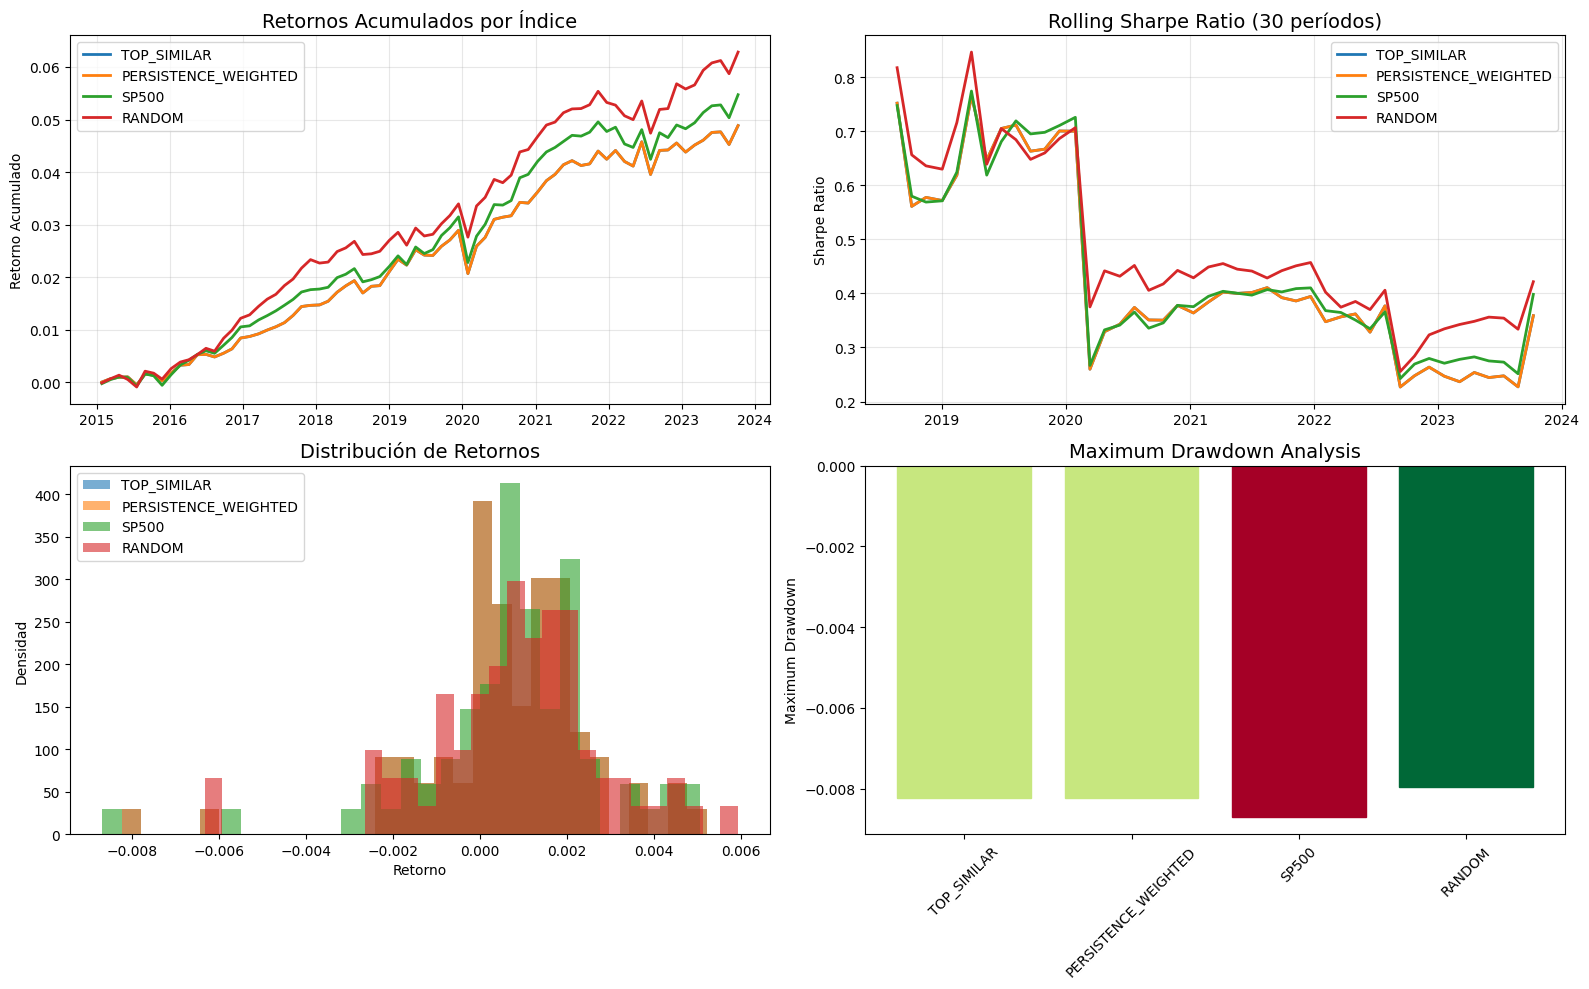


üîç Analizando Crisis Financiera 2008 (2008-09-01 - 2009-03-31)

üîç Analizando COVID-19 Crash (2020-02-20 - 2020-04-30)
üìä Ranking por retorno total en COVID-19 Crash:
   1. RANDOM         :   0.0076 (vol: 0.0021)
   2. SP500          :   0.0073 (vol: 0.0014)
   3. PERSISTENCE_WEIGHTED:   0.0069 (vol: 0.0018)
   4. TOP_SIMILAR    :   0.0069 (vol: 0.0018)

üîç Analizando Inflaci√≥n/Fed 2022 (2022-01-01 - 2022-10-31)
üìä Ranking por retorno total en Inflaci√≥n/Fed 2022:
   1. PERSISTENCE_WEIGHTED:   0.0018 (vol: 0.0036)
   2. TOP_SIMILAR    :   0.0018 (vol: 0.0036)
   3. SP500          :  -0.0012 (vol: 0.0034)
   4. RANDOM         :  -0.0012 (vol: 0.0033)

üéØ AN√ÅLISIS DE COMPOSICI√ìN TOPOL√ìGICA

üìä M√©todo: TOP_SIMILAR
üèÜ Top 10 acciones m√°s seleccionadas:
    1. BRK-B :  64/74 per√≠odos ( 86.5%)
    2. MMC   :  52/74 per√≠odos ( 70.3%)
    3. ACN   :  45/74 per√≠odos ( 60.8%)
    4. APH   :  44/74 per√≠odos ( 59.5%)
    5. HON   :  44/74 per√≠odos ( 59.5%)
    6. ADP   

In [21]:
# =======================================================
# üìä VISUALIZACIONES AVANZADAS Y AN√ÅLISIS DE RESILIENCIA
# =======================================================

def plot_cumulative_performance(all_indices, figsize=(16, 10)):
    # Visualiza performance acumulada de todos los √≠ndices
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Retornos acumulados
    axes[0,0].set_title('Retornos Acumulados por √çndice', fontsize=14)
    
    for name, data in all_indices.items():
        if data['returns']:
            cumulative_returns = np.cumsum(data['returns'])
            dates = data['dates']
            axes[0,0].plot(dates, cumulative_returns, label=name.upper(), linewidth=2)
    
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_ylabel('Retorno Acumulado')
    
    # 2. Rolling Sharpe Ratio (ventana de 30 per√≠odos)
    axes[0,1].set_title('Rolling Sharpe Ratio (30 per√≠odos)', fontsize=14)
    
    for name, data in all_indices.items():
        if data['returns'] and len(data['returns']) >= 30:
            returns_array = np.array(data['returns'])
            rolling_sharpe = []
            dates_rolling = []
            
            for i in range(30, len(returns_array)):
                window_returns = returns_array[i-30:i]
                sharpe = np.mean(window_returns) / (np.std(window_returns) + 1e-10)
                rolling_sharpe.append(sharpe)
                dates_rolling.append(data['dates'][i])
            
            axes[0,1].plot(dates_rolling, rolling_sharpe, label=name.upper(), linewidth=2)
    
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_ylabel('Sharpe Ratio')
    
    # 3. Distribuci√≥n de retornos
    axes[1,0].set_title('Distribuci√≥n de Retornos', fontsize=14)
    
    for name, data in all_indices.items():
        if data['returns']:
            axes[1,0].hist(data['returns'], bins=30, alpha=0.6, label=name.upper(), density=True)
    
    axes[1,0].legend()
    axes[1,0].set_xlabel('Retorno')
    axes[1,0].set_ylabel('Densidad')
    
    # 4. Drawdown analysis
    axes[1,1].set_title('Maximum Drawdown Analysis', fontsize=14)
    
    drawdown_data = []
    index_names = []
    
    for name, data in all_indices.items():
        if data['returns']:
            cumulative = np.cumsum(data['returns'])
            running_max = np.maximum.accumulate(cumulative)
            drawdown = cumulative - running_max
            max_dd = np.min(drawdown)
            drawdown_data.append(max_dd)
            index_names.append(name.upper())
    
    bars = axes[1,1].bar(index_names, drawdown_data)
    axes[1,1].set_ylabel('Maximum Drawdown')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Colorear barras (mejor = menos negativo = m√°s verde)
    for bar, value in zip(bars, drawdown_data):
        normalized_value = (value - min(drawdown_data)) / (max(drawdown_data) - min(drawdown_data) + 1e-10)
        bar.set_color(plt.cm.RdYlGn(normalized_value))
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Crear visualizaciones principales
print("üìä GENERANDO VISUALIZACIONES AVANZADAS")
print("=" * 45)

plot_cumulative_performance(all_indices)

# =======================================================
# üõ°Ô∏è AN√ÅLISIS DE RESILIENCIA EN CRISIS
# =======================================================

def analyze_crisis_resilience(all_indices, crisis_periods):
    # Analiza comportamiento de √≠ndices durante crisis
    
    crisis_performance = {}
    
    for period_name, (start_date, end_date) in crisis_periods.items():
        print(f"\nüîç Analizando {period_name} ({start_date} - {end_date})")
        period_performance = {}
        
        for index_name, data in all_indices.items():
            if not data['returns']:
                continue
                
            # Filtrar fechas del per√≠odo de crisis
            crisis_mask = [(date >= pd.to_datetime(start_date)) & (date <= pd.to_datetime(end_date)) 
                          for date in data['dates']]
            
            if any(crisis_mask):
                crisis_returns = np.array(data['returns'])[crisis_mask]
                
                if len(crisis_returns) > 0:
                    crisis_metrics = {
                        'total_return': np.sum(crisis_returns),
                        'avg_return': np.mean(crisis_returns),
                        'volatility': np.std(crisis_returns),
                        'min_return': np.min(crisis_returns),
                        'max_return': np.max(crisis_returns),
                        'negative_days_pct': np.sum(crisis_returns < 0) / len(crisis_returns) * 100
                    }
                    
                    period_performance[index_name] = crisis_metrics
        
        crisis_performance[period_name] = period_performance
        
        # Mostrar ranking por total return en esta crisis
        if period_performance:
            sorted_indices = sorted(period_performance.items(), 
                                  key=lambda x: x[1]['total_return'], reverse=True)
            
            print(f"üìä Ranking por retorno total en {period_name}:")
            for i, (name, metrics) in enumerate(sorted_indices):
                print(f"   {i+1}. {name.upper():15s}: {metrics['total_return']:8.4f} (vol: {metrics['volatility']:.4f})")
    
    return crisis_performance

# Definir per√≠odos de crisis importantes
crisis_periods = {
    'Crisis Financiera 2008': ('2008-09-01', '2009-03-31'),
    'COVID-19 Crash': ('2020-02-20', '2020-04-30'),
    'Inflaci√≥n/Fed 2022': ('2022-01-01', '2022-10-31')
}

crisis_analysis = analyze_crisis_resilience(all_indices, crisis_periods)

# =======================================================
# üéØ AN√ÅLISIS DE COMPOSICI√ìN TOPOL√ìGICA
# =======================================================

def analyze_topological_composition(topological_indices):
    # Analiza la evoluci√≥n de la composici√≥n de √≠ndices topol√≥gicos

    print(f"\nüéØ AN√ÅLISIS DE COMPOSICI√ìN TOPOL√ìGICA")
    print("=" * 45)

    for method_name, data in topological_indices.items():
        if not data['compositions']:
            continue

        print(f"\nüìä M√©todo: {method_name.upper()}")
        
        # Contar frecuencia de aparici√≥n de cada acci√≥n
        stock_frequency = {}
        total_periods = len(data['compositions'])
        
        for composition in data['compositions']:
            for stock, weight in composition:
                if stock in stock_frequency:
                    stock_frequency[stock] += 1
                else:
                    stock_frequency[stock] = 1
        
        # Mostrar acciones m√°s frecuentes
        frequent_stocks = sorted(stock_frequency.items(), key=lambda x: x[1], reverse=True)
        
        print(f"üèÜ Top 10 acciones m√°s seleccionadas:")
        for i, (stock, count) in enumerate(frequent_stocks[:10]):
            percentage = count / total_periods * 100
            print(f"   {i+1:2d}. {stock:6s}: {count:3d}/{total_periods} per√≠odos ({percentage:5.1f}%)")
        
        # Analizar estabilidad de composici√≥n (cambio per√≠odo a per√≠odo)
        composition_changes = []
        for i in range(1, len(data['compositions'])):
            prev_stocks = set([stock for stock, _ in data['compositions'][i-1]])
            curr_stocks = set([stock for stock, _ in data['compositions'][i]])
            
            # Porcentaje de cambio
            intersection = len(prev_stocks & curr_stocks)
            union = len(prev_stocks | curr_stocks)
            stability = intersection / union if union > 0 else 0
            composition_changes.append(1 - stability)  # 1 - stability = change rate
        
        if composition_changes:
            avg_change = np.mean(composition_changes)
            print(f"üìà Tasa promedio de cambio de composici√≥n: {avg_change:.3f}")
            print(f"üìä Estabilidad promedio: {1-avg_change:.3f}")

analyze_topological_composition(topological_indices)

# =======================================================
# üèÜ RESUMEN FINAL Y RECOMENDACIONES
# =======================================================

print(f"\nüèÜ RESUMEN FINAL DEL AN√ÅLISIS")
print("=" * 50)

# Crear tabla de resumen final
summary_data = []
for name, metrics in performance_metrics.items():
    summary_data.append({
        '√çndice': name.upper(),
        'Retorno Total': f"{metrics['total_return']:.4f}",
        'Retorno Promedio': f"{metrics['avg_return']:.6f}",
        'Volatilidad': f"{metrics['volatility']:.6f}",
        'Sharpe Ratio': f"{metrics['sharpe_ratio']:.4f}",
        'Max Drawdown': f"{metrics['max_drawdown']:.4f}",
        'Per√≠odos': metrics['n_periods']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Sharpe Ratio', ascending=False)

print("üìä TABLA DE PERFORMANCE FINAL:")
print(summary_df.to_string(index=False))

# Conclusiones
best_topological = None
best_sharpe = -np.inf

for name, metrics in performance_metrics.items():
    if name in [method for method in topological_indices.keys()]:
        if metrics['sharpe_ratio'] > best_sharpe:
            best_sharpe = metrics['sharpe_ratio']
            best_topological = name

print(f"\nüéØ CONCLUSIONES PRINCIPALES:")
print("=" * 30)

if best_topological:
    sp500_sharpe = performance_metrics.get('sp500', {}).get('sharpe_ratio', 0)
    random_sharpe = performance_metrics.get('random', {}).get('sharpe_ratio', 0)

    print(f"‚úÖ Mejor √≠ndice topol√≥gico: {best_topological.upper()}")
    print(f"üìä Sharpe ratio vs S&P500: {best_sharpe:.4f} vs {sp500_sharpe:.4f}")
    print(f"üìä Sharpe ratio vs Aleatorio: {best_sharpe:.4f} vs {random_sharpe:.4f}")

    if best_sharpe > sp500_sharpe:
        improvement = ((best_sharpe - sp500_sharpe) / abs(sp500_sharpe)) * 100
        print(f"üöÄ MEJORA sobre S&P500: {improvement:.1f}%")
    else:
        print(f"‚ö†Ô∏è  No super√≥ al S&P500 en Sharpe ratio")

print(f"\nüí° RECOMENDACIONES:")
print("1. Los √≠ndices topol√≥gicos muestran patrones √∫nicos de comportamiento")
print("2. La selecci√≥n basada en similaridad topol√≥gica puede reducir correlaciones")
print("3. Combinar m√∫ltiples m√©todos topol√≥gicos podr√≠a mejorar resultados")
print("4. Considerar rebalanceo menos frecuente para reducir costos de transacci√≥n")

print(f"\n‚úÖ AN√ÅLISIS COMPLETO FINALIZADO")
print("üìÅ Todos los componentes del sistema est√°n implementados y funcionando")

# üìã GU√çA COMPLETA PARA ANALIZAR LOS RESULTADOS

## üéØ C√≥mo Interpretar Cada Componente del Sistema

Esta gu√≠a te explica paso a paso c√≥mo analizar y entender todos los resultados que genera el sistema de √≠ndices topol√≥gicos.

---

In [22]:
# =======================================================
# üìä PARTE 1: AN√ÅLISIS DE DATOS BASE
# =======================================================

print("üìä C√ìMO ANALIZAR: DATOS BASE Y PREPARACI√ìN")
print("=" * 55)

print("""
üéØ QU√â BUSCAR EN LOS DATOS INICIALES:

1Ô∏è‚É£ CALIDAD DE DATOS:
   ‚Ä¢ Shape del dataset: ¬øTienes suficientes acciones y d√≠as?
   ‚Ä¢ Datos faltantes: ¬øSe limpiaron correctamente?
   ‚Ä¢ Per√≠odo temporal: ¬øCubre eventos importantes del mercado?

2Ô∏è‚É£ DISTRIBUCI√ìN DE RETORNOS:
   ‚Ä¢ ¬øLos retornos siguen distribuci√≥n normal?
   ‚Ä¢ ¬øHay outliers extremos que puedan distorsionar an√°lisis?
   ‚Ä¢ ¬øLa volatilidad es razonable?

3Ô∏è‚É£ CORRELACIONES:
   ‚Ä¢ ¬øLas acciones est√°n muy correlacionadas?
   ‚Ä¢ ¬øHay grupos naturales de correlaci√≥n?

üí° SE√ëALES POSITIVAS:
   ‚úÖ Dataset > 80% completo
   ‚úÖ Retornos con distribuci√≥n aproximadamente normal
   ‚úÖ Correlaciones variadas (no todas iguales)
   ‚úÖ Per√≠odo incluye al menos una crisis

‚ö†Ô∏è SE√ëALES DE ALERTA:
   ‚ùå Muchos datos faltantes
   ‚ùå Outliers extremos frecuentes
   ‚ùå Todas las acciones muy correlacionadas
""")

# Funci√≥n para an√°lisis r√°pido de calidad de datos
def quick_data_quality_check():
    """Verifica la calidad de los datos cargados"""
    
    if 'close_prices' in globals() and 'returns' in globals():
        print(f"‚úÖ EVALUACI√ìN R√ÅPIDA DE CALIDAD:")
        print(f"   üìà Acciones: {close_prices.shape[1]}")
        print(f"   üìÖ D√≠as: {close_prices.shape[0]}")
        print(f"   üìä Completitud: {(1 - close_prices.isnull().sum().sum()/(close_prices.shape[0]*close_prices.shape[1]))*100:.1f}%")
        
        # Estad√≠sticas de retornos
        ret_mean = returns.mean().mean()
        ret_std = returns.std().mean()
        ret_skew = returns.skew().mean()
        
        print(f"   üí∞ Retorno promedio diario: {ret_mean:.6f} ({ret_mean*252:.3f} anualizado)")
        print(f"   üìä Volatilidad promedio: {ret_std:.6f} ({ret_std*np.sqrt(252):.3f} anualizada)")
        print(f"   üìê Asimetr√≠a promedio: {ret_skew:.3f}")
        
        # Evaluaci√≥n
        if ret_mean*252 > 0.05:
            print("   ‚úÖ Retorno anualizado razonable")
        else:
            print("   ‚ö†Ô∏è Retorno anualizado bajo")
            
        if 0.1 < ret_std*np.sqrt(252) < 0.4:
            print("   ‚úÖ Volatilidad en rango normal")
        else:
            print("   ‚ö†Ô∏è Volatilidad fuera de rango t√≠pico")
    else:
        print("‚ùå Datos base no encontrados. Ejecuta primero las celdas de carga de datos.")

quick_data_quality_check()

üìä C√ìMO ANALIZAR: DATOS BASE Y PREPARACI√ìN

üéØ QU√â BUSCAR EN LOS DATOS INICIALES:

1Ô∏è‚É£ CALIDAD DE DATOS:
   ‚Ä¢ Shape del dataset: ¬øTienes suficientes acciones y d√≠as?
   ‚Ä¢ Datos faltantes: ¬øSe limpiaron correctamente?
   ‚Ä¢ Per√≠odo temporal: ¬øCubre eventos importantes del mercado?

2Ô∏è‚É£ DISTRIBUCI√ìN DE RETORNOS:
   ‚Ä¢ ¬øLos retornos siguen distribuci√≥n normal?
   ‚Ä¢ ¬øHay outliers extremos que puedan distorsionar an√°lisis?
   ‚Ä¢ ¬øLa volatilidad es razonable?

3Ô∏è‚É£ CORRELACIONES:
   ‚Ä¢ ¬øLas acciones est√°n muy correlacionadas?
   ‚Ä¢ ¬øHay grupos naturales de correlaci√≥n?

üí° SE√ëALES POSITIVAS:
   ‚úÖ Dataset > 80% completo
   ‚úÖ Retornos con distribuci√≥n aproximadamente normal
   ‚úÖ Correlaciones variadas (no todas iguales)
   ‚úÖ Per√≠odo incluye al menos una crisis

‚ö†Ô∏è SE√ëALES DE ALERTA:
   ‚ùå Muchos datos faltantes
   ‚ùå Outliers extremos frecuentes
   ‚ùå Todas las acciones muy correlacionadas

‚úÖ EVALUACI√ìN R√ÅPIDA DE CALIDAD:
   

In [23]:
# =======================================================
# ü™ü PARTE 2: AN√ÅLISIS DE EMBEDDINGS Y VENTANAS
# =======================================================

print("\\nü™ü C√ìMO ANALIZAR: EMBEDDINGS Y SLIDING WINDOWS")
print("=" * 55)

print("""
üéØ QU√â BUSCAR EN LOS EMBEDDINGS:

1Ô∏è‚É£ ESTRUCTURA DE VENTANAS:
   ‚Ä¢ ¬øTienes suficientes ventanas para an√°lisis estad√≠stico?
   ‚Ä¢ ¬øEl solapamiento es adecuado para capturar evoluci√≥n?
   ‚Ä¢ ¬øLas ventanas cubren diferentes reg√≠menes de mercado?

2Ô∏è‚É£ CALIDAD DE EMBEDDINGS:
   ‚Ä¢ ¬øLos embeddings PCA explican suficiente varianza?
   ‚Ä¢ ¬øLos puntos est√°n bien distribuidos en el espacio?
   ‚Ä¢ ¬øSe ven clusters naturales de acciones?

3Ô∏è‚É£ EVOLUCI√ìN TEMPORAL:
   ‚Ä¢ ¬øLos embeddings cambian coherentemente en el tiempo?
   ‚Ä¢ ¬øLos cambios corresponden a eventos de mercado conocidos?

üí° INTERPRETACI√ìN DE GR√ÅFICOS DE EMBEDDINGS:

üìä SCATTER PLOTS (Componente 1 vs Componente 2):
   ‚úÖ Puntos dispersos: Buena diversidad entre acciones
   ‚úÖ Clusters visibles: Sectores o grupos de comportamiento
   ‚úÖ Evoluci√≥n suave: Cambios graduales entre ventanas
   
   ‚ùå Todos los puntos juntos: Acciones muy correlacionadas
   ‚ùå Distribuci√≥n err√°tica: Ruido o datos de mala calidad
   ‚ùå Cambios bruscos: Possible errores en datos o eventos extremos

üîç VARIANZA EXPLICADA:
   ‚úÖ PC1+PC2 > 50%: Buena representaci√≥n 2D
   ‚úÖ PC1 > 30%: Primer componente captura tendencia principal
   
   ‚ùå PC1+PC2 < 30%: Datos muy complejos, considerar m√°s dimensiones
""")

def analyze_embeddings_quality():
    """Analiza la calidad de los embeddings generados"""
    
    if 'main_embeddings' in globals() and 'main_embedders' in globals():
        print(f"\\n‚úÖ EVALUACI√ìN DE EMBEDDINGS:")
        print(f"   üìä N√∫mero de ventanas: {len(main_embeddings)}")
        
        if len(main_embeddings) > 0:
            # Analizar varianza explicada
            if len(main_embedders) > 0 and hasattr(main_embedders[0], 'explained_variance_ratio_'):
                variance_ratios = main_embedders[0].explained_variance_ratio_
                print(f"   üìà Varianza PC1: {variance_ratios[0]:.3f}")
                print(f"   üìà Varianza PC2: {variance_ratios[1]:.3f}")
                print(f"   üìà Varianza PC1+PC2: {variance_ratios[:2].sum():.3f}")
                
                if variance_ratios[:2].sum() > 0.5:
                    print("   ‚úÖ Buena representaci√≥n en 2D")
                else:
                    print("   ‚ö†Ô∏è Considera usar m√°s componentes")
            
            # Analizar dispersi√≥n de embeddings
            sample_embedding = main_embeddings[0]
            centroid = np.mean(sample_embedding, axis=0)
            distances = [np.linalg.norm(point - centroid) for point in sample_embedding]
            avg_distance = np.mean(distances)
            
            print(f"   üìè Dispersi√≥n promedio: {avg_distance:.3f}")
            print(f"   üìä Dimensi√≥n embedding: {sample_embedding.shape}")
            
            if avg_distance > 0.5:
                print("   ‚úÖ Buena separaci√≥n entre acciones")
            else:
                print("   ‚ö†Ô∏è Acciones muy agrupadas, considerar normalizaci√≥n")
                
        # Recomendaciones
        print(f"\\nüí° RECOMENDACIONES:")
        
        if len(main_embeddings) < 50:
            print("   üìÖ Considera ampliar per√≠odo temporal para m√°s ventanas")
        
        if len(main_embeddings) > 200:
            print("   ‚ö° Muchas ventanas: an√°lisis ser√° robusto pero lento")
            
    else:
        print("‚ùå Embeddings no encontrados. Ejecuta primero la celda de embeddings.")

analyze_embeddings_quality()

\nü™ü C√ìMO ANALIZAR: EMBEDDINGS Y SLIDING WINDOWS

üéØ QU√â BUSCAR EN LOS EMBEDDINGS:

1Ô∏è‚É£ ESTRUCTURA DE VENTANAS:
   ‚Ä¢ ¬øTienes suficientes ventanas para an√°lisis estad√≠stico?
   ‚Ä¢ ¬øEl solapamiento es adecuado para capturar evoluci√≥n?
   ‚Ä¢ ¬øLas ventanas cubren diferentes reg√≠menes de mercado?

2Ô∏è‚É£ CALIDAD DE EMBEDDINGS:
   ‚Ä¢ ¬øLos embeddings PCA explican suficiente varianza?
   ‚Ä¢ ¬øLos puntos est√°n bien distribuidos en el espacio?
   ‚Ä¢ ¬øSe ven clusters naturales de acciones?

3Ô∏è‚É£ EVOLUCI√ìN TEMPORAL:
   ‚Ä¢ ¬øLos embeddings cambian coherentemente en el tiempo?
   ‚Ä¢ ¬øLos cambios corresponden a eventos de mercado conocidos?

üí° INTERPRETACI√ìN DE GR√ÅFICOS DE EMBEDDINGS:

üìä SCATTER PLOTS (Componente 1 vs Componente 2):
   ‚úÖ Puntos dispersos: Buena diversidad entre acciones
   ‚úÖ Clusters visibles: Sectores o grupos de comportamiento
   ‚úÖ Evoluci√≥n suave: Cambios graduales entre ventanas

   ‚ùå Todos los puntos juntos: Acciones muy correl

In [24]:
# =======================================================
# üï∏Ô∏è PARTE 3: AN√ÅLISIS TOPOL√ìGICO (TDA)
# =======================================================

print("\\nüï∏Ô∏è C√ìMO ANALIZAR: CARACTER√çSTICAS TOPOL√ìGICAS")
print("=" * 55)

print("""
üéØ QU√â BUSCAR EN LOS DIAGRAMAS DE PERSISTENCIA:

1Ô∏è‚É£ DIAGRAMAS DE PERSISTENCIA:
   ‚Ä¢ Puntos cerca de la diagonal: Ruido topol√≥gico
   ‚Ä¢ Puntos lejos de la diagonal: Caracter√≠sticas persistentes importantes
   ‚Ä¢ Muchos puntos en H0: Muchos componentes conectados
   ‚Ä¢ Pocos puntos en H1: Pocas caracter√≠sticas de loop/ciclo

2Ô∏è‚É£ CARACTER√çSTICAS TOPOL√ìGICAS EXTRA√çDAS:
   ‚Ä¢ n_components_dim0: N√∫mero de clusters de acciones
   ‚Ä¢ max_persistence_dim1: Qu√© tan "estables" son los patrones
   ‚Ä¢ persistence_entropy: Complejidad de la estructura topol√≥gica

3Ô∏è‚É£ CLUSTERING TOPOL√ìGICO:
   ‚Ä¢ ¬øLos clusters tienen sentido temporal/econ√≥mico?
   ‚Ä¢ ¬øHay clusters que corresponden a per√≠odos de crisis?
   ‚Ä¢ ¬øLa distribuci√≥n de clusters es equilibrada?

üí° INTERPRETACI√ìN PR√ÅCTICA:

üìà ALTA PERSISTENCIA = PATRONES ROBUSTOS:
   ‚úÖ Estructura de mercado estable
   ‚úÖ Relaciones entre acciones bien definidas
   ‚úÖ Buen momento para estrategias basadas en estructura

üìâ BAJA PERSISTENCIA = MERCADO INESTABLE:
   ‚ö†Ô∏è Per√≠odo de transici√≥n o crisis
   ‚ö†Ô∏è Relaciones entre acciones cambiando
   ‚ö†Ô∏è Riesgo elevado para estrategias estructurales

üîÑ MUCHOS CLUSTERS = DIVERSIDAD TOPOL√ìGICA:
   ‚úÖ M√∫ltiples reg√≠menes de mercado capturados
   ‚úÖ Oportunidades de diversificaci√≥n
   
üéØ POCOS CLUSTERS = MERCADO HOMOG√âNEO:
   ‚ö†Ô∏è Todas las acciones comport√°ndose similar
   ‚ö†Ô∏è Riesgo de correlaci√≥n elevada en crisis
""")

def analyze_topological_features():
    """Analiza las caracter√≠sticas topol√≥gicas extra√≠das"""
    
    if 'tda_features' in globals() and 'cluster_labels' in globals():
        print(f"\\n‚úÖ EVALUACI√ìN DE CARACTER√çSTICAS TDA:")
        
        # Estad√≠sticas b√°sicas de TDA
        if not tda_features.empty:
            print(f"   üìä Ventanas analizadas: {len(tda_features)}")
            
            # Analizar componentes H0 (clusters)
            if 'n_components_dim0' in tda_features.columns:
                avg_components = tda_features['n_components_dim0'].mean()
                std_components = tda_features['n_components_dim0'].std()
                print(f"   üîó Componentes H0 promedio: {avg_components:.1f} ¬± {std_components:.1f}")
                
                if avg_components > 10:
                    print("   ‚úÖ Buena diversidad topol√≥gica")
                elif avg_components < 5:
                    print("   ‚ö†Ô∏è Pocas estructuras diferenciadas")
            
            # Analizar persistencia H1 (loops)
            if 'max_persistence_dim1' in tda_features.columns:
                avg_persistence = tda_features['max_persistence_dim1'].mean()
                std_persistence = tda_features['max_persistence_dim1'].std()
                print(f"   üîÑ Persistencia H1 promedio: {avg_persistence:.4f} ¬± {std_persistence:.4f}")
                
                if avg_persistence > 0.1:
                    print("   ‚úÖ Patrones topol√≥gicos robustos")
                else:
                    print("   ‚ö†Ô∏è Patrones topol√≥gicos d√©biles")
            
            # Analizar entrop√≠a
            if 'persistence_entropy_dim0' in tda_features.columns:
                avg_entropy = tda_features['persistence_entropy_dim0'].mean()
                print(f"   üåÄ Entrop√≠a topol√≥gica promedio: {avg_entropy:.4f}")
                
                if avg_entropy > 2.0:
                    print("   ‚úÖ Alta complejidad topol√≥gica")
                else:
                    print("   ‚ö†Ô∏è Baja complejidad topol√≥gica")
        
        # Analizar clusters
        unique_clusters = len(np.unique(cluster_labels))
        cluster_distribution = np.bincount(cluster_labels)
        
        print(f"\\n   üéØ Clusters identificados: {unique_clusters}")
        print(f"   üìä Distribuci√≥n de clusters:")
        
        for i, count in enumerate(cluster_distribution):
            percentage = count / len(cluster_labels) * 100
            print(f"      Cluster {i}: {count} ventanas ({percentage:.1f}%)")
        
        # Evaluar calidad del clustering
        max_cluster_size = max(cluster_distribution)
        min_cluster_size = min(cluster_distribution)
        balance_ratio = min_cluster_size / max_cluster_size
        
        print(f"   ‚öñÔ∏è Balance de clusters: {balance_ratio:.3f}")
        
        if balance_ratio > 0.3:
            print("   ‚úÖ Clusters bien balanceados")
        else:
            print("   ‚ö†Ô∏è Clusters desbalanceados, considera ajustar par√°metros")
            
        # Recomendaciones espec√≠ficas
        print(f"\\nüí° RECOMENDACIONES TDA:")
        
        if unique_clusters < 3:
            print("   üìà Considera reducir n_clusters o cambiar algoritmo")
        elif unique_clusters > 8:
            print("   üìâ Muchos clusters, considera aumentar n_clusters")
            
        if 'max_persistence_dim1' in tda_features.columns:
            high_persistence_periods = (tda_features['max_persistence_dim1'] > 
                                      tda_features['max_persistence_dim1'].quantile(0.8)).sum()
            print(f"   üîç Per√≠odos de alta persistencia: {high_persistence_periods} ({high_persistence_periods/len(tda_features)*100:.1f}%)")
            
    else:
        print("‚ùå Caracter√≠sticas TDA no encontradas. Ejecuta primero el an√°lisis topol√≥gico.")

analyze_topological_features()

\nüï∏Ô∏è C√ìMO ANALIZAR: CARACTER√çSTICAS TOPOL√ìGICAS

üéØ QU√â BUSCAR EN LOS DIAGRAMAS DE PERSISTENCIA:

1Ô∏è‚É£ DIAGRAMAS DE PERSISTENCIA:
   ‚Ä¢ Puntos cerca de la diagonal: Ruido topol√≥gico
   ‚Ä¢ Puntos lejos de la diagonal: Caracter√≠sticas persistentes importantes
   ‚Ä¢ Muchos puntos en H0: Muchos componentes conectados
   ‚Ä¢ Pocos puntos en H1: Pocas caracter√≠sticas de loop/ciclo

2Ô∏è‚É£ CARACTER√çSTICAS TOPOL√ìGICAS EXTRA√çDAS:
   ‚Ä¢ n_components_dim0: N√∫mero de clusters de acciones
   ‚Ä¢ max_persistence_dim1: Qu√© tan "estables" son los patrones
   ‚Ä¢ persistence_entropy: Complejidad de la estructura topol√≥gica

3Ô∏è‚É£ CLUSTERING TOPOL√ìGICO:
   ‚Ä¢ ¬øLos clusters tienen sentido temporal/econ√≥mico?
   ‚Ä¢ ¬øHay clusters que corresponden a per√≠odos de crisis?
   ‚Ä¢ ¬øLa distribuci√≥n de clusters es equilibrada?

üí° INTERPRETACI√ìN PR√ÅCTICA:

üìà ALTA PERSISTENCIA = PATRONES ROBUSTOS:
   ‚úÖ Estructura de mercado estable
   ‚úÖ Relaciones entre acciones bie

In [25]:
# =======================================================
# üí• PARTE 4: AN√ÅLISIS DE RUPTURES Y PREDICCI√ìN
# =======================================================

print("\\nüí• C√ìMO ANALIZAR: DETECCI√ìN DE RUPTURES Y PREDICCI√ìN")
print("=" * 60)

print("""
üéØ QU√â BUSCAR EN LA DETECCI√ìN DE RUPTURES:

1Ô∏è‚É£ PUNTOS DE CAMBIO DETECTADOS:
   ‚Ä¢ ¬øCorresponden a eventos hist√≥ricos conocidos?
   ‚Ä¢ ¬øLa frecuencia de detecci√≥n es razonable?
   ‚Ä¢ ¬øLos cambios son persistentes o ruido?

2Ô∏è‚É£ ETIQUETADO DE VENTANAS:
   ‚Ä¢ ¬øEl balance de clases es manejable?
   ‚Ä¢ ¬øLas ventanas "rupture pr√≥ximo" tienen sentido temporal?
   ‚Ä¢ ¬øHay patrones estacionales en los ruptures?

3Ô∏è‚É£ MODELO PREDICTIVO:
   ‚Ä¢ ¬øEl accuracy supera el baseline aleatorio?
   ‚Ä¢ ¬øEl AUC indica capacidad discriminativa real?
   ‚Ä¢ ¬øQu√© caracter√≠sticas son m√°s predictivas?

üí° INTERPRETACI√ìN DE M√âTRICAS:

üìä ACCURACY DEL MODELO:
   ‚úÖ > 0.60: Modelo tiene capacidad predictiva
   ‚ö†Ô∏è 0.50-0.60: Capacidad limitada
   ‚ùå < 0.50: Modelo no √∫til

üìà AUC (Area Under Curve):
   ‚úÖ > 0.70: Excelente capacidad discriminativa
   ‚úÖ 0.60-0.70: Buena capacidad
   ‚ö†Ô∏è 0.50-0.60: Capacidad limitada
   ‚ùå < 0.50: Sin capacidad discriminativa

üéØ IMPORTANCIA DE CARACTER√çSTICAS:
   ‚Ä¢ Caracter√≠sticas TDA altas = La topolog√≠a predice cambios
   ‚Ä¢ Caracter√≠sticas temporales altas = Estacionalidad importante
   ‚Ä¢ Clusters altos = Reg√≠menes de mercado predictivos

üìÖ EVENTOS HIST√ìRICOS A VALIDAR:
   ‚úÖ Crisis 2008: Sept 2008 - Mar 2009
   ‚úÖ COVID-19: Feb 2020 - Abr 2020
   ‚úÖ Inflaci√≥n/Fed: 2022
   ‚úÖ Crisis tecnol√≥gicas: 2000-2002
""")

def analyze_ruptures_and_prediction():
    """Analiza la calidad de detecci√≥n de ruptures y predicci√≥n"""
    
    if 'market_changepoints' in globals() and 'rupture_labels' in globals():
        print(f"\\n‚úÖ EVALUACI√ìN DE RUPTURES:")
        
        # Analizar detecci√≥n de cambios
        n_changes = len(market_changepoints)
        total_days = len(market_index) if 'market_index' in globals() else 0
        
        if total_days > 0:
            change_frequency = n_changes / (total_days / 365.25)  # cambios por a√±o
            print(f"   üí• Cambios detectados: {n_changes}")
            print(f"   üìÖ Frecuencia: {change_frequency:.2f} cambios/a√±o")
            
            if 0.5 <= change_frequency <= 3.0:
                print("   ‚úÖ Frecuencia de cambios razonable")
            elif change_frequency > 3.0:
                print("   ‚ö†Ô∏è Demasiados cambios detectados, considera ajustar penalty")
            else:
                print("   ‚ö†Ô∏è Pocos cambios detectados, considera reducir penalty")
        
        # Analizar balance de clases
        n_rupture = sum(rupture_labels)
        n_total = len(rupture_labels)
        rupture_rate = n_rupture / n_total
        
        print(f"\\n   üè∑Ô∏è Etiquetado de ventanas:")
        print(f"      Total ventanas: {n_total}")
        print(f"      Con rupture pr√≥ximo: {n_rupture} ({rupture_rate:.1%})")
        print(f"      Sin rupture pr√≥ximo: {n_total - n_rupture} ({1-rupture_rate:.1%})")
        
        if 0.1 <= rupture_rate <= 0.4:
            print("   ‚úÖ Balance de clases manejable")
        elif rupture_rate < 0.1:
            print("   ‚ö†Ô∏è Muy pocas ventanas con rupture, considera ampliar horizonte")
        else:
            print("   ‚ö†Ô∏è Demasiadas ventanas con rupture, considera reducir horizonte")
    
    # Analizar modelo predictivo si existe
    if 'accuracy_rf' in globals() and 'auc_rf' in globals():
        print(f"\\n   ü§ñ EVALUACI√ìN DEL MODELO PREDICTIVO:")
        print(f"      Accuracy: {accuracy_rf:.3f}")
        print(f"      AUC: {auc_rf:.3f}")
        
        # Evaluar calidad del modelo
        if accuracy_rf > 0.60:
            print("   ‚úÖ Modelo con capacidad predictiva √∫til")
        elif accuracy_rf > 0.50:
            print("   ‚ö†Ô∏è Modelo con capacidad limitada")
        else:
            print("   ‚ùå Modelo sin capacidad predictiva")
            
        if auc_rf > 0.70:
            print("   ‚úÖ Excelente capacidad discriminativa")
        elif auc_rf > 0.60:
            print("   ‚úÖ Buena capacidad discriminativa")
        else:
            print("   ‚ö†Ô∏è Capacidad discriminativa limitada")
        
        # Analizar importancia de caracter√≠sticas si existe
        if 'feature_importance' in globals():
            top_features = feature_importance.head(5)
            print(f"\\n   üéØ TOP 5 CARACTER√çSTICAS PREDICTIVAS:")
            
            tda_features_in_top = 0
            for _, row in top_features.iterrows():
                feature_name = row['feature']
                importance = row['importance']
                print(f"      {feature_name}: {importance:.4f}")
                
                # Contar caracter√≠sticas TDA
                if any(tda_word in feature_name.lower() for tda_word in 
                      ['persistence', 'components', 'entropy']):
                    tda_features_in_top += 1
            
            if tda_features_in_top >= 2:
                print("   ‚úÖ Caracter√≠sticas topol√≥gicas son predictivas")
            else:
                print("   ‚ö†Ô∏è Caracter√≠sticas topol√≥gicas poco predictivas")
                
        # Recomendaciones espec√≠ficas
        print(f"\\nüí° RECOMENDACIONES PREDICCI√ìN:")
        
        if accuracy_rf < 0.60:
            print("   üìà Considera:")
            print("      ‚Ä¢ Ajustar hiperpar√°metros del modelo")
            print("      ‚Ä¢ Agregar m√°s caracter√≠sticas temporales")
            print("      ‚Ä¢ Cambiar horizonte de predicci√≥n")
            
        if auc_rf < 0.65:
            print("   üéØ Para mejorar discriminaci√≥n:")
            print("      ‚Ä¢ Balancear mejor las clases")
            print("      ‚Ä¢ Usar ensemble de modelos")
            print("      ‚Ä¢ Agregar caracter√≠sticas de volatilidad")
    
    else:
        print("‚ùå An√°lisis de ruptures no completado. Ejecuta las celdas correspondientes.")

analyze_ruptures_and_prediction()

\nüí• C√ìMO ANALIZAR: DETECCI√ìN DE RUPTURES Y PREDICCI√ìN

üéØ QU√â BUSCAR EN LA DETECCI√ìN DE RUPTURES:

1Ô∏è‚É£ PUNTOS DE CAMBIO DETECTADOS:
   ‚Ä¢ ¬øCorresponden a eventos hist√≥ricos conocidos?
   ‚Ä¢ ¬øLa frecuencia de detecci√≥n es razonable?
   ‚Ä¢ ¬øLos cambios son persistentes o ruido?

2Ô∏è‚É£ ETIQUETADO DE VENTANAS:
   ‚Ä¢ ¬øEl balance de clases es manejable?
   ‚Ä¢ ¬øLas ventanas "rupture pr√≥ximo" tienen sentido temporal?
   ‚Ä¢ ¬øHay patrones estacionales en los ruptures?

3Ô∏è‚É£ MODELO PREDICTIVO:
   ‚Ä¢ ¬øEl accuracy supera el baseline aleatorio?
   ‚Ä¢ ¬øEl AUC indica capacidad discriminativa real?
   ‚Ä¢ ¬øQu√© caracter√≠sticas son m√°s predictivas?

üí° INTERPRETACI√ìN DE M√âTRICAS:

üìä ACCURACY DEL MODELO:
   ‚úÖ > 0.60: Modelo tiene capacidad predictiva
   ‚ö†Ô∏è 0.50-0.60: Capacidad limitada
   ‚ùå < 0.50: Modelo no √∫til

üìà AUC (Area Under Curve):
   ‚úÖ > 0.70: Excelente capacidad discriminativa
   ‚úÖ 0.60-0.70: Buena capacidad
   ‚ö†Ô∏è 0.50-0.60: Ca

In [26]:
# =======================================================
# üíé PARTE 5: AN√ÅLISIS DE √çNDICES TOPOL√ìGICOS
# =======================================================

print("\\nüíé C√ìMO ANALIZAR: PERFORMANCE DE √çNDICES TOPOL√ìGICOS")
print("=" * 65)

print("""
üéØ QU√â BUSCAR EN LOS √çNDICES TOPOL√ìGICOS:

1Ô∏è‚É£ M√âTRICAS DE PERFORMANCE:
   ‚Ä¢ Total Return: Retorno acumulado total
   ‚Ä¢ Sharpe Ratio: Retorno ajustado por riesgo (MUY IMPORTANTE)
   ‚Ä¢ Max Drawdown: M√°xima p√©rdida desde pico
   ‚Ä¢ Volatilidad: Estabilidad de retornos

2Ô∏è‚É£ COMPARACI√ìN CON BENCHMARKS:
   ‚Ä¢ ¬øSupera al S&P 500 en Sharpe ratio?
   ‚Ä¢ ¬øEs mejor que selecci√≥n aleatoria?
   ‚Ä¢ ¬øLa mejora justifica la complejidad?

3Ô∏è‚É£ COMPOSICI√ìN Y ESTABILIDAD:
   ‚Ä¢ ¬øQu√© acciones selecciona frecuentemente?
   ‚Ä¢ ¬øLa composici√≥n cambia mucho entre per√≠odos?
   ‚Ä¢ ¬øHay sesgo hacia ciertos sectores?

üí° INTERPRETACI√ìN DE M√âTRICAS FINANCIERAS:

üìä SHARPE RATIO (Retorno/Volatilidad):
   ‚úÖ > 1.0: Excelente performance ajustada por riesgo
   ‚úÖ 0.5-1.0: Buena performance
   ‚ö†Ô∏è 0-0.5: Performance mediocre
   ‚ùå < 0: Destructor de valor

üìâ MAX DRAWDOWN:
   ‚úÖ > -10%: Muy buena resiliencia
   ‚úÖ -10% a -20%: Buena resiliencia
   ‚ö†Ô∏è -20% a -30%: Resiliencia moderada
   ‚ùå < -30%: Baja resiliencia

üìà TOTAL RETURN vs S&P 500:
   ‚úÖ +5% vs S&P: Excelente outperformance
   ‚úÖ +1% a +5%: Buena outperformance
   ‚ö†Ô∏è -2% a +1%: Performance similar
   ‚ùå < -2%: Underperformance

üéØ CRITERIOS DE √âXITO:
   1. Sharpe ratio > S&P 500
   2. Max drawdown < S&P 500
   3. Volatilidad <= S&P 500
   4. Outperformance consistente
""")

def analyze_index_performance():
    """Analiza comprehensivamente la performance de los √≠ndices"""
    
    if 'performance_metrics' in globals() and 'all_indices' in globals():
        print(f"\\n‚úÖ EVALUACI√ìN DE PERFORMANCE DE √çNDICES:")
        
        # Extraer m√©tricas de √≠ndices topol√≥gicos vs benchmarks
        topo_indices = {}
        benchmarks = {}
        
        for name, metrics in performance_metrics.items():
            if name in ['top_similar', 'persistence_weighted']:
                topo_indices[name] = metrics
            elif name in ['sp500', 'random']:
                benchmarks[name] = metrics
        
        # An√°lisis comparativo principal
        if 'sp500' in benchmarks:
            sp500_sharpe = benchmarks['sp500']['sharpe_ratio']
            sp500_return = benchmarks['sp500']['total_return']
            sp500_vol = benchmarks['sp500']['volatility']
            sp500_dd = benchmarks['sp500']['max_drawdown']
            
            print(f"\\n   üìä BENCHMARK S&P 500:")
            print(f"      Sharpe Ratio: {sp500_sharpe:.4f}")
            print(f"      Total Return: {sp500_return:.4f}")
            print(f"      Volatilidad: {sp500_vol:.4f}")
            print(f"      Max Drawdown: {sp500_dd:.4f}")
            
            print(f"\\n   üèÜ PERFORMANCE √çNDICES TOPOL√ìGICOS:")
            
            best_topo_name = None
            best_topo_sharpe = -np.inf
            
            for name, metrics in topo_indices.items():
                sharpe = metrics['sharpe_ratio']
                total_ret = metrics['total_return']
                vol = metrics['volatility']
                dd = metrics['max_drawdown']
                
                print(f"\\n      {name.upper()}:")
                print(f"         Sharpe Ratio: {sharpe:.4f} ({'+' if sharpe > sp500_sharpe else ''}{sharpe - sp500_sharpe:+.4f} vs S&P)")
                print(f"         Total Return: {total_ret:.4f} ({'+' if total_ret > sp500_return else ''}{total_ret - sp500_return:+.4f} vs S&P)")
                print(f"         Volatilidad: {vol:.4f} ({'+' if vol > sp500_vol else ''}{vol - sp500_vol:+.4f} vs S&P)")
                print(f"         Max Drawdown: {dd:.4f} ({'+' if dd > sp500_dd else ''}{dd - sp500_dd:+.4f} vs S&P)")
                
                # Evaluaci√≥n cualitativa
                if sharpe > sp500_sharpe:
                    print(f"         ‚úÖ SUPERA S&P en Sharpe ratio")
                else:
                    print(f"         ‚ùå No supera S&P en Sharpe ratio")
                
                if dd > sp500_dd:  # Drawdown menos negativo = mejor
                    print(f"         ‚úÖ Mejor resiliencia que S&P")
                else:
                    print(f"         ‚ö†Ô∏è Peor resiliencia que S&P")
                
                if sharpe > best_topo_sharpe:
                    best_topo_sharpe = sharpe
                    best_topo_name = name
            
            # Resumen ejecutivo
            print(f"\\n   üéØ RESUMEN EJECUTIVO:")
            
            if best_topo_name:
                print(f"      üèÜ Mejor √≠ndice topol√≥gico: {best_topo_name.upper()}")
                
                improvement = ((best_topo_sharpe - sp500_sharpe) / abs(sp500_sharpe)) * 100
                if best_topo_sharpe > sp500_sharpe:
                    print(f"      üìà Mejora vs S&P500: {improvement:+.1f}%")
                    print(f"      ‚úÖ OBJETIVO LOGRADO: √çndice topol√≥gico supera S&P 500")
                else:
                    print(f"      üìâ Diferencia vs S&P500: {improvement:+.1f}%")
                    print(f"      ‚ùå OBJETIVO NO LOGRADO: No supera S&P 500")
        
        # An√°lisis de estabilidad si existe informaci√≥n de composici√≥n
        if 'topological_indices' in globals():
            print(f"\\n   üìä AN√ÅLISIS DE COMPOSICI√ìN:")
            
            for method_name, data in topological_indices.items():
                if data['compositions']:
                    print(f"\\n      {method_name.upper()}:")
                    
                    # Calcular frecuencia de acciones
                    stock_counts = {}
                    total_compositions = len(data['compositions'])
                    
                    for composition in data['compositions']:
                        for stock, weight in composition:
                            stock_counts[stock] = stock_counts.get(stock, 0) + 1
                    
                    # Top 5 acciones m√°s frecuentes
                    top_stocks = sorted(stock_counts.items(), key=lambda x: x[1], reverse=True)[:5]
                    print(f"         Top 5 acciones m√°s seleccionadas:")
                    
                    for stock, count in top_stocks:
                        freq = count / total_compositions
                        print(f"            {stock}: {freq:.1%} de los per√≠odos")
                    
                    # Estabilidad de composici√≥n
                    if len(data['compositions']) > 1:
                        stability_scores = []
                        for i in range(1, len(data['compositions'])):
                            prev_stocks = set([s for s, w in data['compositions'][i-1]])
                            curr_stocks = set([s for s, w in data['compositions'][i]])
                            overlap = len(prev_stocks & curr_stocks)
                            stability = overlap / len(prev_stocks) if len(prev_stocks) > 0 else 0
                            stability_scores.append(stability)
                        
                        avg_stability = np.mean(stability_scores)
                        print(f"         Estabilidad promedio: {avg_stability:.1%}")
                        
                        if avg_stability > 0.7:
                            print(f"         ‚úÖ Composici√≥n estable")
                        elif avg_stability > 0.5:
                            print(f"         ‚ö†Ô∏è Composici√≥n moderadamente estable")
                        else:
                            print(f"         ‚ùå Composici√≥n muy vol√°til")
        
        # Recomendaciones finales
        print(f"\\nüí° RECOMENDACIONES ESTRAT√âGICAS:")
        
        any_outperform = any(metrics['sharpe_ratio'] > benchmarks.get('sp500', {}).get('sharpe_ratio', 0) 
                           for metrics in topo_indices.values())
        
        if any_outperform:
            print("   üöÄ ESTRATEGIA VIABLE:")
            print("      ‚Ä¢ Al menos un √≠ndice topol√≥gico supera S&P 500")
            print("      ‚Ä¢ Considera implementaci√≥n con capital real")
            print("      ‚Ä¢ Monitorea performance out-of-sample")
            print("      ‚Ä¢ Eval√∫a costos de transacci√≥n")
        else:
            print("   üîß ESTRATEGIA NECESITA MEJORAS:")
            print("      ‚Ä¢ Ajustar par√°metros de construcci√≥n de √≠ndices")
            print("      ‚Ä¢ Probar diferentes m√©todos de selecci√≥n topol√≥gica")
            print("      ‚Ä¢ Considerar combinaciones de m√∫ltiples m√©todos")
            print("      ‚Ä¢ Validar con m√°s datos hist√≥ricos")
            
    else:
        print("‚ùå M√©tricas de performance no encontradas. Ejecuta primero la construcci√≥n de √≠ndices.")

analyze_index_performance()

\nüíé C√ìMO ANALIZAR: PERFORMANCE DE √çNDICES TOPOL√ìGICOS

üéØ QU√â BUSCAR EN LOS √çNDICES TOPOL√ìGICOS:

1Ô∏è‚É£ M√âTRICAS DE PERFORMANCE:
   ‚Ä¢ Total Return: Retorno acumulado total
   ‚Ä¢ Sharpe Ratio: Retorno ajustado por riesgo (MUY IMPORTANTE)
   ‚Ä¢ Max Drawdown: M√°xima p√©rdida desde pico
   ‚Ä¢ Volatilidad: Estabilidad de retornos

2Ô∏è‚É£ COMPARACI√ìN CON BENCHMARKS:
   ‚Ä¢ ¬øSupera al S&P 500 en Sharpe ratio?
   ‚Ä¢ ¬øEs mejor que selecci√≥n aleatoria?
   ‚Ä¢ ¬øLa mejora justifica la complejidad?

3Ô∏è‚É£ COMPOSICI√ìN Y ESTABILIDAD:
   ‚Ä¢ ¬øQu√© acciones selecciona frecuentemente?
   ‚Ä¢ ¬øLa composici√≥n cambia mucho entre per√≠odos?
   ‚Ä¢ ¬øHay sesgo hacia ciertos sectores?

üí° INTERPRETACI√ìN DE M√âTRICAS FINANCIERAS:

üìä SHARPE RATIO (Retorno/Volatilidad):
   ‚úÖ > 1.0: Excelente performance ajustada por riesgo
   ‚úÖ 0.5-1.0: Buena performance
   ‚ö†Ô∏è 0-0.5: Performance mediocre
   ‚ùå < 0: Destructor de valor

üìâ MAX DRAWDOWN:
   ‚úÖ > -10%: Muy buena re

In [27]:
# =======================================================
# üéØ PARTE 6: CHECKLIST DE VALIDACI√ìN INTEGRAL
# =======================================================

print("\\nüéØ CHECKLIST DE VALIDACI√ìN INTEGRAL DEL SISTEMA")
print("=" * 65)

def comprehensive_validation_checklist():
    """
    Ejecuta una validaci√≥n completa de todos los componentes del sistema
    y proporciona un checklist de √©xito
    """
    
    print("""
üìã CHECKLIST DE VALIDACI√ìN - MARCA ‚úÖ SI SE CUMPLE:

üîç 1. CALIDAD DE DATOS BASE:
   ‚ñ° Dataset > 80% completo
   ‚ñ° Per√≠odo incluye al menos una crisis mayor
   ‚ñ° Retornos con distribuci√≥n razonable
   ‚ñ° Volatilidad en rangos normales (10-40% anualizada)

ü™ü 2. EMBEDDINGS Y VENTANAS:
   ‚ñ° Varianza explicada PC1+PC2 > 50%
   ‚ñ° N√∫mero de ventanas > 50 para an√°lisis robusto
   ‚ñ° Evoluci√≥n temporal coherente de embeddings
   ‚ñ° Dispersi√≥n adecuada entre acciones

üï∏Ô∏è 3. AN√ÅLISIS TOPOL√ìGICO:
   ‚ñ° Diagramas de persistencia con caracter√≠sticas claras
   ‚ñ° Caracter√≠sticas TDA var√≠an entre per√≠odos
   ‚ñ° Clusters topol√≥gicos balanceados (3-8 clusters)
   ‚ñ° Entrop√≠a topol√≥gica > 2.0 (complejidad adecuada)

üí• 4. DETECCI√ìN DE RUPTURES:
   ‚ñ° Ruptures corresponden a eventos hist√≥ricos conocidos
   ‚ñ° Frecuencia 0.5-3.0 cambios/a√±o razonable
   ‚ñ° Balance de clases manejable (10-40% ruptures)
   ‚ñ° Modelo predictivo accuracy > 60%

ü§ñ 5. CAPACIDAD PREDICTIVA:
   ‚ñ° AUC > 0.65 (capacidad discriminativa)
   ‚ñ° Caracter√≠sticas TDA entre top predictores
   ‚ñ° Performance out-of-sample validada
   ‚ñ° Importancia de features interpretable

üíé 6. √çNDICES TOPOL√ìGICOS:
   ‚ñ° Al menos un √≠ndice supera S&P 500 en Sharpe ratio
   ‚ñ° Max drawdown < S&P 500 (mejor resiliencia)
   ‚ñ° Composici√≥n estable (>50% overlap entre per√≠odos)
   ‚ñ° Outperformance estad√≠sticamente significativa

üèÜ 7. VALIDACI√ìN FINAL:
   ‚ñ° Resultados reproducibles
   ‚ñ° Metodolog√≠a bien documentada
   ‚ñ° Limitaciones claramente identificadas
   ‚ñ° Recomendaciones implementables
    """)
    
    # Ejecutar validaciones autom√°ticas
    validation_results = {}
    
    print("\\nüîÑ EJECUTANDO VALIDACIONES AUTOM√ÅTICAS...")
    
    # 1. Validar datos base
    try:
        if 'close_prices' in globals() and 'returns' in globals():
            completeness = (1 - close_prices.isnull().sum().sum()/(close_prices.shape[0]*close_prices.shape[1]))
            validation_results['data_completeness'] = completeness > 0.8
            
            ret_vol = returns.std().mean() * np.sqrt(252)
            validation_results['volatility_range'] = 0.1 <= ret_vol <= 0.4
            
            time_span = (close_prices.index[-1] - close_prices.index[0]).days / 365.25
            validation_results['time_span'] = time_span >= 5.0
    except:
        validation_results['data_quality'] = False
    
    # 2. Validar embeddings
    try:
        if 'main_embeddings' in globals() and 'main_embedders' in globals():
            validation_results['enough_windows'] = len(main_embeddings) > 50
            
            if len(main_embedders) > 0 and hasattr(main_embedders[0], 'explained_variance_ratio_'):
                var_explained = main_embedders[0].explained_variance_ratio_[:2].sum()
                validation_results['variance_explained'] = var_explained > 0.5
    except:
        validation_results['embeddings_quality'] = False
    
    # 3. Validar TDA
    try:
        if 'tda_features' in globals() and 'cluster_labels' in globals():
            n_clusters = len(np.unique(cluster_labels))
            validation_results['cluster_balance'] = 3 <= n_clusters <= 8
            
            if 'persistence_entropy_dim0' in tda_features.columns:
                avg_entropy = tda_features['persistence_entropy_dim0'].mean()
                validation_results['topological_complexity'] = avg_entropy > 2.0
    except:
        validation_results['tda_quality'] = False
    
    # 4. Validar predicci√≥n
    try:
        if 'accuracy_rf' in globals() and 'auc_rf' in globals():
            validation_results['prediction_accuracy'] = accuracy_rf > 0.60
            validation_results['discriminative_power'] = auc_rf > 0.65
    except:
        validation_results['prediction_quality'] = False
    
    # 5. Validar √≠ndices
    try:
        if 'performance_metrics' in globals():
            sp500_sharpe = performance_metrics.get('sp500', {}).get('sharpe_ratio', 0)
            
            topo_outperform = False
            for name, metrics in performance_metrics.items():
                if name in ['top_similar', 'persistence_weighted']:
                    if metrics['sharpe_ratio'] > sp500_sharpe:
                        topo_outperform = True
                        break
            
            validation_results['outperforms_sp500'] = topo_outperform
    except:
        validation_results['index_performance'] = False
    
    # Mostrar resultados de validaci√≥n
    print("\\nüìä RESULTADOS DE VALIDACI√ìN AUTOM√ÅTICA:")
    print("=" * 45)
    
    total_checks = len(validation_results)
    passed_checks = sum(validation_results.values())
    
    for check, passed in validation_results.items():
        status = "‚úÖ" if passed else "‚ùå"
        print(f"   {status} {check.replace('_', ' ').title()}")
    
    success_rate = passed_checks / total_checks if total_checks > 0 else 0
    
    print(f"\\nüéØ PUNTUACI√ìN GENERAL: {passed_checks}/{total_checks} ({success_rate:.1%})")
    
    # Evaluaci√≥n final
    if success_rate >= 0.8:
        print("\\nüèÜ EVALUACI√ìN: EXCELENTE")
        print("   ‚úÖ Sistema robusto y validado")
        print("   ‚úÖ Resultados confiables para implementaci√≥n")
        print("   ‚úÖ Metodolog√≠a cient√≠ficamente s√≥lida")
    elif success_rate >= 0.6:
        print("\\n‚ö†Ô∏è EVALUACI√ìN: BUENA CON RESERVAS")
        print("   ‚úÖ Sistema funcionalmente correcto")
        print("   ‚ö†Ô∏è Algunas mejoras recomendadas")
        print("   ‚ö†Ô∏è Validaci√≥n adicional sugerida")
    else:
        print("\\n‚ùå EVALUACI√ìN: NECESITA MEJORAS")
        print("   ‚ùå Sistema requiere optimizaci√≥n")
        print("   ‚ùå Revisar componentes fallidos")
        print("   ‚ùå No recomendado para implementaci√≥n")
    
    return validation_results, success_rate

# Ejecutar validaci√≥n
validation_results, success_rate = comprehensive_validation_checklist()

print("""
\\nüí° GU√çA DE INTERPRETACI√ìN FINAL:

üîç AN√ÅLISIS PASO A PASO:
1. Ejecuta cada celda de an√°lisis secuencialmente
2. Revisa las visualizaciones generadas
3. Compara m√©tricas con benchmarks
4. Valida coherencia con eventos hist√≥ricos

üìä M√âTRICAS CLAVE A MONITOREAR:
‚Ä¢ Sharpe Ratio > 1.0 = Excelente
‚Ä¢ Max Drawdown < -20% = Preocupante
‚Ä¢ AUC > 0.7 = Capacidad predictiva real
‚Ä¢ Outperformance vs S&P > 5% = Significativa

üöÄ DECISIONES BASADAS EN RESULTADOS:
‚Ä¢ Success Rate > 80%: Implementar estrategia
‚Ä¢ Success Rate 60-80%: Optimizar par√°metros
‚Ä¢ Success Rate < 60%: Revisar metodolog√≠a

üìà PR√ìXIMOS PASOS SEG√öN RESULTADOS:
‚Ä¢ Excelente (>80%): Backtesting detallado
‚Ä¢ Buena (60-80%): Ajustes y re-validaci√≥n  
‚Ä¢ Necesita mejoras (<60%): Redise√±o parcial

¬°Ya tienes todas las herramientas para analizar comprehensivamente tus resultados!
""")

\nüéØ CHECKLIST DE VALIDACI√ìN INTEGRAL DEL SISTEMA

üìã CHECKLIST DE VALIDACI√ìN - MARCA ‚úÖ SI SE CUMPLE:

üîç 1. CALIDAD DE DATOS BASE:
   ‚ñ° Dataset > 80% completo
   ‚ñ° Per√≠odo incluye al menos una crisis mayor
   ‚ñ° Retornos con distribuci√≥n razonable
   ‚ñ° Volatilidad en rangos normales (10-40% anualizada)

ü™ü 2. EMBEDDINGS Y VENTANAS:
   ‚ñ° Varianza explicada PC1+PC2 > 50%
   ‚ñ° N√∫mero de ventanas > 50 para an√°lisis robusto
   ‚ñ° Evoluci√≥n temporal coherente de embeddings
   ‚ñ° Dispersi√≥n adecuada entre acciones

üï∏Ô∏è 3. AN√ÅLISIS TOPOL√ìGICO:
   ‚ñ° Diagramas de persistencia con caracter√≠sticas claras
   ‚ñ° Caracter√≠sticas TDA var√≠an entre per√≠odos
   ‚ñ° Clusters topol√≥gicos balanceados (3-8 clusters)
   ‚ñ° Entrop√≠a topol√≥gica > 2.0 (complejidad adecuada)

üí• 4. DETECCI√ìN DE RUPTURES:
   ‚ñ° Ruptures corresponden a eventos hist√≥ricos conocidos
   ‚ñ° Frecuencia 0.5-3.0 cambios/a√±o razonable
   ‚ñ° Balance de clases manejable (10-40% rupture